In [1]:
import pandas as pd
import numpy as np
import json
import re

import math
from collections import Counter
import tqdm
import numpy as np
import pandas as pd
from collections import Counter
import math
import joblib

import numpy as np
import pandas as pd
from collections import Counter
import math
from concurrent.futures import ThreadPoolExecutor, as_completed
import numpy as np
# 你的 Node 和 Network 类定义在这里

from scipy.stats.qmc import LatinHypercube
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.stats import pearsonr
import joblib

In [1]:
import joblib
import math
from collections import Counter
from scipy.stats import entropy

class Node:
    def __init__(self, name, node_type, risk=None, sentiment=None, intensity=None):
        self.name = name
        self.type = node_type
        self.risk = risk
        self.sentiment = sentiment
        self.intensity = intensity
        self.influencers = []
        # self.sigma = sigma

    def add_influencer(self, influencer):
        self.influencers.append(influencer)

    def calculate_n_major(self):
        # 仅适用于 o_people 类型的节点
        sentiment_counter = Counter([inf.sentiment for inf in self.influencers if inf.sentiment])
        if sentiment_counter:
            return max(sentiment_counter.values())  # 返回最多的情绪类别的数量
        return 0

    def calculate_influencers_sentiment_distribution(self):
        sentiment_counts = Counter(inf.sentiment for inf in self.influencers if inf.sentiment)
        n_high = sentiment_counts.get('H', 0)
        n_low = sentiment_counts.get('L', 0)
        n_middle = sentiment_counts.get('M', 0)
        return n_high, n_low, n_middle
    
    def update_m_media(self, params):
        if self.type == 'm_media':
            alpha = params['alpha']
            # n_high, n_low, n_middle = self.calculate_influencers_sentiment_distribution() # 计算情绪分布
            d = params['d']
            n_high_global = params['n_high']
            n_low_global = params['n_low']
            n_middle_global = params['n_middle']
            sentiment_counter = Counter([inf.sentiment for inf in self.influencers if inf.sentiment])
            # 添加默认情绪类别为 0
            for sentiment in ['H', 'M', 'L']:
                if sentiment not in sentiment_counter:
                    sentiment_counter[sentiment] = 0
            
            n_high_local = sentiment_counter.get('H', 0)
            n_low_local = sentiment_counter.get('L', 0)
            n_middle_local = sentiment_counter.get('M', 0)

            # n_high = (n_high_local + n_high_global) / 2
            # n_low = (n_low_local + n_low_global) / 2
            # n_middle = (n_middle_local + n_middle_global) / 2

            n_high = n_high_local
            n_low = n_low_local
            n_middle = n_middle_local

            if n_middle > n_high and n_middle > n_low:
                pass

            elif n_high > n_middle and n_high > n_low:
                d = 2 * n_high - n_middle - n_low
                Pu = 1 - math.exp(-alpha * d)
                if Pu > np.random.random():
                    self.risk = 'NR'

            elif n_low > n_middle and n_low > n_high:
                d = 2 * n_low - n_middle - n_high
                Pu = 1 - math.exp(-alpha * d)
                if Pu > np.random.random():
                    self.risk = 'R'
                # else:
                #     self.risk = 'NR'
            
            else:   # 三者相等
                d = n_middle
                Pu = 1 - math.exp(-alpha * d)
                if Pu > np.random.random():
                    self.risk = 'NR'

    def update_m_media_gv(self, params, government_effect_m):
        if self.type == 'm_media':
            alpha = params['alpha']
            g_m = params['g_m']
            # n_high, n_low, n_middle = self.calculate_influencers_sentiment_distribution() # 计算情绪分布
            d = params['d']
            n_high_global = params['n_high']
            n_low_global = params['n_low']
            n_middle_global = params['n_middle']
            sentiment_counter = Counter([inf.sentiment for inf in self.influencers if inf.sentiment])
            # 添加默认情绪类别为 0
            for sentiment in ['H', 'M', 'L']:
                if sentiment not in sentiment_counter:
                    sentiment_counter[sentiment] = 0
            
            n_high_local = sentiment_counter.get('H', 0)
            n_low_local = sentiment_counter.get('L', 0)
            n_middle_local = sentiment_counter.get('M', 0)

            # n_high = (n_high_local + n_high_global) / 2
            # n_low = (n_low_local + n_low_global) / 2
            # n_middle = (n_middle_local + n_middle_global) / 2

            n_high = n_high_local
            n_low = n_low_local
            n_middle = n_middle_local

            if n_middle > n_high and n_middle > n_low:
                Pu = g_m
                if Pu > np.random.random():
                    self.risk = 'NR'

            elif n_high > n_middle and n_high > n_low:
                d = 2 * n_high - n_middle - n_low
                Pu = (1 - math.exp(-alpha * d) + g_m)
                if Pu > np.random.random():
                    self.risk = 'NR'
                

            elif n_low > n_middle and n_low > n_high:
                d = 2 * n_low - n_middle - n_high
                Pu = (1 - math.exp(-alpha * d) + g_m) # 在这里我添加了政府对主流媒体的影响，它是一个开口朝下的二次函数，使得降低风险概率增加
                if Pu > np.random.random():
                    self.risk = 'R'
                # else:
                #     self.risk = 'NR' 

            else:
                d = n_middle
                Pu = (1 - math.exp(-alpha * d) + g_m)
                if Pu > np.random.random():
                    self.risk = 'NR'
                # else:
                #     self.risk = 'R'

        
    def update_w_media(self, params):
        if self.type == 'w_media':

            beta = params['beta']
            # n_middle = params['n_middle']
            # n_high = params['n_high']
            # n_low = params['n_low']
            n_high_global = params['n_high']
            n_low_global = params['n_low']
            n_middle_global = params['n_middle']
            risk_global_m = params['risk_m']
            norisk_global_m = params['norisk_m']
            risk_global_w = params['risk_w']
            norisk_global_w = params['norisk_w']

            sentiment_counter = Counter([inf.sentiment for inf in self.influencers if inf.sentiment])
            # 添加默认情绪类别为 0
            for sentiment in ['H', 'M', 'L']:
                if sentiment not in sentiment_counter:
                    sentiment_counter[sentiment] = 0
            
            n_high_local = sentiment_counter.get('H', 0)
            n_low_local = sentiment_counter.get('L', 0)
            n_middle_local = sentiment_counter.get('M', 0)

            risk_counter = Counter([inf.risk for inf in self.influencers if inf.risk])
            # 添加默认风险类别为 0
            for risk in ['R', 'NR']:
                if risk not in risk_counter:
                    risk_counter[risk] = 0
            risk_local = risk_counter.get('R', 0)
            norisk_local = risk_counter.get('NR', 0) 

                       

            # n_high = (n_high_local + n_high_global) / 2
            # n_low = (n_low_local + n_low_global) / 2
            # n_middle = (n_middle_local + n_middle_global) / 2

            n_high = n_high_local
            n_low = n_low_local
            n_middle = n_middle_local

            total_sentiments = sum(sentiment_counter.values())

            if total_sentiments > 0:
                # 计算情绪的概率分布
                sentiment_probs = [sentiment_counter[s] / total_sentiments for s in ['H', 'M', 'L']]
            else:
                # 如果没有情绪数据，设定为均匀分布或采取其他处理
                sentiment_probs = [1/3, 1/3, 1/3]  # 例如设定为均匀分布
                # print("Warning: No sentiment data, using default equal probabilities.")
                
            sentiment_entropy = entropy(sentiment_probs)

            d = sentiment_entropy

            if n_high > n_middle and n_high > n_low:
                pass
            
            elif n_low > n_middle and n_low > n_high:
                # d = n_low
                Pv_1 = 1 - math.exp(-beta * d)
                if Pv_1 > np.random.random():
                    self.risk = 'R'
                # else:
                #     self.risk = 'NR'

            elif n_middle > n_high and n_middle > n_low:
                # d = n_middle
                Pv_1 = 1 - math.exp(-beta * d)
                if Pv_1 > np.random.random():
                    self.risk = 'R'
                # else:
                #     self.risk = 'NR'
            
            elif n_low == n_middle and n_low == n_high:
                # d = n_middle
                Pv_1 = 1 - math.exp(-beta * d)
                if Pv_1 > np.random.random():
                    self.risk = 'R'
                # else:
                #     self.risk = 'NR'
            
            else: # 三者相等
                # d = n_middle
                Pv_1 = 1 - math.exp(-beta * d)
                if Pv_1 > np.random.random():
                    self.risk = 'R'
            # else:
            #     self.risk = 'R'

            norisk = norisk_local 
            risk = risk_local 
            # norisk = norisk_global_m + norisk_global_w
            # risk = risk_global_m + risk_global_w
            Pv_2 = (np.tanh(norisk - risk) + 1) / 2  # 使用的是局部信息
            if Pv_2 > np.random.random():
                self.risk = 'NR'
            # else:
            #     self.risk = 'NR'

    
    def update_w_media_gv(self, params, government_effect_w):
        # 特殊时期，自媒体会降低风险报道的概率
        if self.type == 'w_media':

            beta = params['beta']
            # n_middle = params['n_middle']
            # n_high = params['n_high']
            # n_low = params['n_low']
            sentiment_counter = Counter([inf.sentiment for inf in self.influencers if inf.sentiment])
            # 添加默认情绪类别为 0
            for sentiment in ['H', 'M', 'L']:
                if sentiment not in sentiment_counter:
                    sentiment_counter[sentiment] = 0
            
            n_high = sentiment_counter.get('H', 0)
            n_low = sentiment_counter.get('L', 0)
            n_middle = sentiment_counter.get('M', 0)

            risk_global_m = params['risk_m']
            norisk_global_m = params['norisk_m']

            risk_global_w = params['risk_w']
            norisk_global_w = params['norisk_w']


            risk_counter = Counter([inf.risk for inf in self.influencers if inf.risk])
            # 添加默认风险类别为 0
            for risk in ['R', 'NR']:
                if risk not in risk_counter:
                    risk_counter[risk] = 0

            risk_local = risk_counter.get('R', 0)
            norisk_local = risk_counter.get('NR', 0)

            total_sentiments = sum(sentiment_counter.values())

            if total_sentiments > 0:
                # 计算情绪的概率分布
                sentiment_probs = [sentiment_counter[s] / total_sentiments for s in ['H', 'M', 'L']]
            else:
                # 如果没有情绪数据，设定为均匀分布或采取其他处理
                sentiment_probs = [1/3, 1/3, 1/3]  # 例如设定为均匀分布
                # print("Warning: No sentiment data, using default equal probabilities.")
                
            sentiment_entropy = entropy(sentiment_probs)

            d = sentiment_entropy
            
            if n_high > n_middle and n_high > n_low:
                pass
            
            elif n_low > n_middle and n_low > n_high:
                # d = n_low
                Pv_1 = 1 - math.exp(-beta * d)
                if Pv_1 > np.random.random():
                    self.risk = 'R'
                # else:
                #     self.risk = 'NR'

            elif n_middle > n_high and n_middle > n_low:
                # d = n_middle
                Pv_1 = 1 - math.exp(-beta * d)
                if Pv_1 > np.random.random():
                    self.risk = 'R'
                # else:
                #     self.risk = 'NR'
            
            elif n_low == n_middle and n_low == n_high:
                # d = n_middle
                Pv_1 = 1 - math.exp(-beta * d)
                if Pv_1 > np.random.random():
                    self.risk = 'R'
                # else:
                #     self.risk = 'NR'
            
            else: # 三者相等
                pass
            
            norisk = norisk_local 
            risk = risk_local 
            # norisk = norisk_global_m + norisk_global_w
            # risk = risk_global_m + risk_global_w
            Pv_2 = (np.tanh(norisk - risk) + 1) / 2  # 使用的是局部信息
            if Pv_2 > np.random.random():
                self.risk = 'NR'
            # else:
            #     self.risk = 'R'


    def update_o_people(self, params):
        if self.type == 'o_people':
            intensity = self.intensity
            # 这里的r应该规范化
            risk_m = params['risk_m']
            risk_w = params['risk_w']
            norisk_m = params['norisk_m']
            norisk_w = params['norisk_w']
            theta = params['theta']
            sigma = params['sigma']
            zeta = params['zeta']
            miu = params['miu']
            risk_global = risk_m + risk_w
            norisk_global = norisk_m + norisk_w
            risk_counter = Counter([inf.risk for inf in self.influencers if inf.risk])
            # 添加默认风险类别为 0
            for risk in ['R', 'NR']:
                if risk not in risk_counter:
                    risk_counter[risk] = 0

            risk_local = risk_counter.get('R', 0)
            norisk_local = risk_counter.get('NR', 0)

            # risk = (risk_local + risk_global) / 2
            # norisk = (norisk_local + risk_global) / 2
            # risk = risk_local
            # norisk = norisk_local

            risk = risk_global
            norisk = norisk_global

            sentiment_counter = Counter([inf.sentiment for inf in self.influencers if inf.sentiment])
            # 添加默认情绪类别为 0
            for sentiment in ['H', 'M', 'L']:
                if sentiment not in sentiment_counter:
                    sentiment_counter[sentiment] = 0

            if self.sentiment == 'H':
                d1 = norisk - risk
                d2 = sentiment_counter.get('M', 0) + sentiment_counter.get('L', 0) - sentiment_counter.get('H', 0)
            elif self.sentiment == 'M':
                # 绝对值
                d1 = abs(norisk - risk)  # 这里选用了绝对值，是因为我们认为风险和非风险的差距越大，越容易产生情绪的变化
                d2 = sentiment_counter.get('H', 0) + sentiment_counter.get('L', 0) - sentiment_counter.get('M', 0)
            elif self.sentiment == 'L':
                d1 = risk - norisk
                d2 = sentiment_counter.get('H', 0) + sentiment_counter.get('M', 0) - sentiment_counter.get('L', 0)
            
            # intensity越小，越容易产生情绪的变化
            intensity = intensity - ((np.tanh(theta * d1) + np.tanh(sigma * d2)) + 2) / 4 # 这里我们添加了risk信息机制还有homophily机制

            d = risk - norisk
            Pw = (1 + np.tanh(d)) / 2

            if intensity > 1:
                intensity = 1
            elif intensity < 0:
                intensity = 0

            # 判断所有 sentiment_counter 的值是否相等
            def all_values_equal(d):
                values = list(d.values())
                return values.count(values[0]) == len(values)
            
            # 修改后的代码
            if intensity > np.random.random():
                if self.sentiment == 'M':
                    if np.random.random() < zeta:
                        if Pw > np.random.random():
                            self.sentiment = 'H'
                        else:
                            self.sentiment = 'L'
                        # else:
                        #     self.sentiment = np.random.choice(['H', 'L'])
                    else:
                        if all_values_equal(sentiment_counter):
                            # self.sentiment = 'L'  # 如果 sentiment_counter 中所有值相等，保留现有的 sentiment
                            # self.sentiment = np.random.choice(['H', 'L'])
                            if Pw > np.random.random():
                                self.sentiment = 'H'
                            else:
                                self.sentiment = 'L'
                            # else:   
                            #     self.sentiment = np.random.choice(['H', 'L'])
                        else:
                            self.sentiment = max(sentiment_counter, key=sentiment_counter.get)

                elif self.sentiment == 'H':
                    if np.random.random() < zeta:
                        self.sentiment = 'M'
                    else:
                        if all_values_equal(sentiment_counter):
                            # self.sentiment = np.random.choice(['M', 'L'])
                            if Pw > np.random.random():
                                self.sentiment = 'H'
                            else:
                                self.sentiment = 'L'
                            # else:   
                            #     self.sentiment = np.random.choice(['H', 'L'])
                        else:
                            self.sentiment = max(sentiment_counter, key=sentiment_counter.get)
                            
                elif self.sentiment == 'L':
                    if np.random.random() < zeta:
                        self.sentiment = 'M'
                    else:
                        if all_values_equal(sentiment_counter):
                            # self.sentiment = np.random.choice(['H', 'M'])
                            if Pw > np.random.random():
                                self.sentiment = 'H'
                            else:
                                self.sentiment = 'L'
                            # else:   
                            #     self.sentiment = np.random.choice(['H', 'L'])
                        else:
                            self.sentiment = max(sentiment_counter, key=sentiment_counter.get)

    
    def update_o_people_gv(self, params, government_effect_o):
        # print('update_o_people_gv')
        if self.type == 'o_people':
            intensity = self.intensity
            # 这里的r应该规范化
            risk_m = params['risk_m']
            risk_w = params['risk_w']
            norisk_m = params['norisk_m']
            norisk_w = params['norisk_w']
            theta = params['theta']
            sigma = params['sigma']
            zeta = params['zeta']
            miu = params['miu']

            risk_global = risk_m + risk_w
            norisk_global = norisk_m + norisk_w
            risk_counter = Counter([inf.risk for inf in self.influencers if inf.risk])
            # 添加默认风险类别为 0
            for risk in ['R', 'NR']:
                if risk not in risk_counter:
                    risk_counter[risk] = 0
            risk_local = risk_counter.get('R', 0)
            norisk_local = risk_counter.get('NR', 0)

            # risk = (risk_local + risk_global) / 2
            # norisk = (norisk_local + risk_global) / 2

            # risk = risk_local
            # norisk = norisk_local

            risk = risk_global
            norisk = norisk_global



            sentiment_counter = Counter([inf.sentiment for inf in self.influencers if inf.sentiment])
            # 添加默认情绪类别为 0
            for sentiment in ['H', 'M', 'L']:
                if sentiment not in sentiment_counter:
                    sentiment_counter[sentiment] = 0

            if self.sentiment == 'H':
                d1 = norisk - risk
                d2 = sentiment_counter.get('M', 0) + sentiment_counter.get('L', 0) - sentiment_counter.get('H', 0)
            elif self.sentiment == 'M':
                # 绝对值
                d1 = abs(norisk - risk)
                d2 = sentiment_counter.get('H', 0) + sentiment_counter.get('L', 0) - sentiment_counter.get('M', 0)
            elif self.sentiment == 'L':
                d1 = risk - norisk
                d2 = sentiment_counter.get('H', 0) + sentiment_counter.get('M', 0) - sentiment_counter.get('L', 0)
            
            intensity = intensity - ((np.tanh(theta * d1) + np.tanh(sigma * d2)) + 2) / 4 # 这里我们添加了risk信息机制还有homophily机制

            d = risk - norisk
            # Pw = 1 - math.exp(-miu * d)
            Pw = (1 + np.tanh(d)) / 2
            if intensity > 1:
                intensity = 1
            elif intensity < 0:
                intensity = 0
            
            # 判断所有 sentiment_counter 的值是否相等
            def all_values_equal(d):
                values = list(d.values())
                return values.count(values[0]) == len(values)
            
            # 修改后的代码
            if intensity > np.random.random():
                if self.sentiment == 'M':
                    if np.random.random() < zeta:
                        if Pw > np.random.random():
                            self.sentiment = 'H'
                        else:
                            self.sentiment = 'L'
                        # else:
                        #     self.sentiment = np.random.choice(['H', 'L'])
                    else:
                        if all_values_equal(sentiment_counter):
                            # self.sentiment = 'L'  # 如果 sentiment_counter 中所有值相等，保留现有的 sentiment
                            # self.sentiment = np.random.choice(['H', 'L'])
                            if Pw > np.random.random():
                                self.sentiment = 'H'
                            else:
                                self.sentiment = 'L'
                            # else:   
                            #     self.sentiment = np.random.choice(['H', 'L'])
                        else:
                            self.sentiment = max(sentiment_counter, key=sentiment_counter.get)

                elif self.sentiment == 'H':
                    if np.random.random() < zeta:
                        self.sentiment = 'M'
                    else:
                        if all_values_equal(sentiment_counter):
                            # self.sentiment = np.random.choice(['M', 'L'])
                            if Pw > np.random.random():
                                self.sentiment = 'H'
                            else:
                                self.sentiment = 'L'
                            # else:   
                            #     self.sentiment = np.random.choice(['H', 'L'])
                        else:
                            self.sentiment = max(sentiment_counter, key=sentiment_counter.get)
                            
                elif self.sentiment == 'L':
                    if np.random.random() < zeta:
                        self.sentiment = 'M'
                    else:
                        if all_values_equal(sentiment_counter):
                            # self.sentiment = np.random.choice(['H', 'M'])
                            if Pw > np.random.random():
                                self.sentiment = 'H'
                            else:
                                self.sentiment = 'L'
                            # else:   
                            #     self.sentiment = np.random.choice(['H', 'L'])
                        else:
                            self.sentiment = max(sentiment_counter, key=sentiment_counter.get)


    def forward(self, params):
        self.update_m_media(params)
        self.update_w_media(params)
        self.update_o_people(params)

    def forward_gv(self, params, government_effect_m, government_effect_w=0, government_effect_o=0):
        self.update_m_media_gv(params, government_effect_m)
        self.update_w_media_gv(params, government_effect_w)
        self.update_o_people_gv(params, government_effect_o)

class Network:
    def __init__(self):
        self.nodes = {}

    def add_node(self, node):
        self.nodes[node.name] = node

    def calculate_sentiment_distribution(self):
        sentiment_counts = Counter(node.sentiment for node in self.nodes.values() if node.type == 'o_people')
        return sentiment_counts

    def simulate_step(self, alpha, beta, theta, sigma, zeta, miu, g_m):
        sentiment_counts = self.calculate_sentiment_distribution()
        property = self.calculate_state_proportions()
        risk_m = property['m_media']['R']
        risk_w = property['w_media']['R']
        norisk_m = property['m_media']['NR']
        norisk_w = property['w_media']['NR']
        d = (sentiment_counts['H'] + sentiment_counts['L'] - sentiment_counts['M']) / (sentiment_counts['M'] + 1)
        params = {
            'alpha': alpha, 
            'beta': beta, 
            'theta': theta, 
            'sigma': sigma,
            'zeta': zeta, 
            'miu': miu,
            'g_m': g_m,
            'd': d,
            'n_high': sentiment_counts['H'], 
            'n_low': sentiment_counts['L'], 
            'n_middle': sentiment_counts['M'],
            'risk_m': risk_m,
            'risk_w': risk_w,
            'norisk_m': norisk_m,
            'norisk_w': norisk_w
        }
        for node in self.nodes.values():
            node.forward(params)
    
    def simulate_step_gv(self, alpha, beta, theta, sigma, zeta, miu, g_m,
                         government_effect_m, government_effect_w=0, government_effect_o=0):
        sentiment_counts = self.calculate_sentiment_distribution()
        property = self.calculate_state_proportions()
        risk_m = property['m_media']['R']
        risk_w = property['w_media']['R']
        norisk_m = property['m_media']['NR']
        norisk_w = property['w_media']['NR']
        d = (sentiment_counts['H'] + sentiment_counts['L'] - sentiment_counts['M']) / (sentiment_counts['M'] + 1)
        params = {
            'alpha': alpha, 
            'beta': beta, 
            'theta': theta, 
            'sigma': sigma,
            'zeta': zeta,
            'miu': miu,
            'g_m': g_m,
            'd': d,
            'n_high': sentiment_counts['H'], 
            'n_low': sentiment_counts['L'], 
            'n_middle': sentiment_counts['M'],
            'risk_m': risk_m,
            'risk_w': risk_w,
            'norisk_m': norisk_m,
            'norisk_w': norisk_w
        }
        for node in self.nodes.values():
            node.forward_gv(params, government_effect_m, government_effect_w, government_effect_o)

    def simulate_steps(self, steps, alpha, beta, theta, sigma, zeta, miu, g_m,
                       delta_1, delta_2, delta_3, delta_4, 
                       delta_5, delta_6, delta_7, delta_8,
                       gamma_1, gamma_2, gamma_3, gamma_4, 
                       cutoff_1 = 0, cutoff_2 = 20, cutoff_3 = 48, cutoff_4 = 62,
                       duration_1 = 14, duration_2 = 20, duration_3 = 14, duration_4 = 20):
        
        # 用于存储每个时间步的状态占比数据
        middle_1 = round(cutoff_1 + 0.5 * duration_1)
        middle_2 = round(cutoff_2 + 0.5 * duration_2)
        middle_3 = round(cutoff_3 + 0.5 * (duration_3+duration_2))
        ini_distribution = self.calculate_state_proportions()
        history = []
        history.append(ini_distribution)
        for t in range(steps):
            if t >= cutoff_1 and t <= cutoff_1 + duration_1:
                # government_effect = np.random.uniform(0.1, 0.15)
                # 我要使用duration来写一个二次函数，来模拟政府对自媒体的影响，开头向上，二次项的系数是delta， delta_1是负数
                # government_effect_m = delta_1 * ((t - middle_1)/duration_1) ** 2 + delta_2
                government_effect_m = 0
                # print(f"第{t}天存在政府对主流媒体的影响，影响效应是{government_effect_m}")

                # government_effect_w = delta_3 * ((t - middle_1)/duration_1) ** 2 + delta_4
                government_effect_w = 0

                # 我要使用duration来写一个二次函数，来模拟政府对公众情绪的影响，开头向下，二次项的系数是gamma，gamma_1是负数
                # government_effect_o = gamma_1 * ((t - middle_1)/duration_1) ** 2 + gamma_2

                # self.simulate_step_gv(alpha, beta, theta, sigma, zeta, miu,
                #                       government_effect_m=government_effect_m, government_effect_w=government_effect_w, government_effect_o=0)
                self.simulate_step(alpha, beta, theta, sigma, zeta, miu, g_m)
                proportions = self.calculate_state_proportions()
                history.append(proportions) 

            elif t >= cutoff_2 and t <= cutoff_2 + duration_2:
                # government_effect = np.random.uniform(0.1, 0.15)
                # 我要使用duration来写一个二次函数，来模拟政府对自媒体的影响，开头向上，二次项的系数是delta， delta_1是负数
                # government_effect_m = -(delta_5 * ((t - middle_2)/duration_2) ** 2 + delta_6)
                government_effect_m = 0

                # government_effect_w = -(delta_7 * ((t - middle_2)/duration_2) ** 2 + delta_8)
                government_effect_w = 0

                # 我要使用duration来写一个二次函数，来模拟政府对公众情绪的影响，开头向下，二次项的系数是gamma，gamma_1是负数
                # government_effect_o = gamma_3 * ((t - middle_3)/(duration_2+duration_3)) ** 2 + gamma_4

                # print(f"t={t}, government_effect_w={government_effect_w}, government_effect_o={government_effect_o}")

                self.simulate_step_gv(alpha, beta, theta, sigma, zeta, miu, g_m,
                                      government_effect_m=government_effect_m, government_effect_w=government_effect_w, government_effect_o=0)
                # self.simulate_step(alpha, beta, theta, sigma, zeta, miu)
                proportions = self.calculate_state_proportions()
                history.append(proportions)
                
            elif t >= cutoff_3 and t <= cutoff_3 + duration_3:
                # government_effect_m = delta_5 * ((t - middle_3)/(duration_3)) ** 2 + delta_6
                government_effect_m = 0

                # government_effect_w = delta_3 * ((t - middle_2)/duration_2) ** 2 + delta_4
                government_effect_w = 0

                # 我要使用duration来写一个二次函数，来模拟政府对公众情绪的影响，开头向下，二次项的系数是gamma，gamma_1是负数
                # government_effect_o = gamma_3 * ((t - middle_3)/(duration_2+duration_3)) ** 2 + gamma_4

                # print(f"t={t}, government_effect_w={government_effect_w}, government_effect_o={government_effect_o}")

                # self.simulate_step_gv(alpha, beta, theta, sigma, zeta,miu,
                #                       government_effect_m=government_effect_m, government_effect_w=government_effect_w, government_effect_o=0)
                self.simulate_step(alpha, beta, theta, sigma, zeta, miu, g_m)
                proportions = self.calculate_state_proportions()
                history.append(proportions)
            
            elif t >= cutoff_4 and t <= cutoff_4 + duration_4:  
                # government_effect_m = -(delta_7 * ((t - middle_3)/(duration_3)) ** 2 + delta_8)
                government_effect_m = 0

                # government_effect_w = delta_3 * ((t - middle_2)/duration_2) ** 2 + delta_4
                government_effect_w = 0

                # 我要使用duration来写一个二次函数，来模拟政府对公众情绪的影响，开头向下，二次项的系数是gamma，gamma_1是负数
                # government_effect_o = gamma_3 * ((t - middle_3)/(duration_2+duration_3)) ** 2 + gamma_4

                # print(f"t={t}, government_effect_w={government_effect_w}, government_effect_o={government_effect_o}")

                # self.simulate_step_gv(alpha, beta, theta, sigma, zeta, miu,
                #                       government_effect_m=government_effect_m, government_effect_w=government_effect_w, government_effect_o=0)
                self.simulate_step(alpha, beta, theta, sigma, zeta, miu, g_m)
                proportions = self.calculate_state_proportions()
                history.append(proportions)

            else:
                self.simulate_step(alpha, beta, theta, sigma, zeta, miu, g_m)
                proportions = self.calculate_state_proportions()
                history.append(proportions)

        return history


    def calculate_state_proportions(self):
        # 初始化状态计数器
        states = {
            'm_media': Counter({'R': 0, 'NR': 0}),
            'w_media': Counter({'R': 0, 'NR': 0}),
            'o_people': Counter({'H': 0, 'M': 0, 'L': 0})
        }
        
        # 统计各类节点的状态
        for node in self.nodes.values():
            if node.type in ['m_media', 'w_media']:
                states[node.type][node.risk] += 1
            elif node.type == 'o_people':
                states[node.type][node.sentiment] += 1
        # 计算占比
        proportions = {type: {state: count / sum(states[type].values()) for state, count in states[type].items()} for type in states}
        return proportions

    def display(self):
        for name, node in self.nodes.items():
            print(f"{name} ({node.type}): Risk={node.risk}, Sentiment={node.sentiment}, Influencers={[inf.name for inf in node.influencers]}")




In [2]:
# 导入经验数据
w_media_empirical = pd.read_csv('./output/empirical/w_media_risk_data_7days.csv')
o_people_empirical = pd.read_csv('./output/empirical/sentiment_data_7days.csv')
m_media_empirical = pd.read_csv('./output/empirical/m_media_risk_data_7days.csv')

In [3]:
emp_w_risk_p = dict(zip(w_media_empirical['period_id_3d'], w_media_empirical['risk_p']))
emp_m_risk_p = dict(zip(m_media_empirical['period_id_3d'], m_media_empirical['risk_p']))
emp_sentiment_high_p = dict(zip(o_people_empirical['period_id_3d'], o_people_empirical['high_p']))
emp_sentiment_middle_p = dict(zip(o_people_empirical['period_id_3d'], o_people_empirical['middle_p']))
emp_sentiment_low_p = dict(zip(o_people_empirical['period_id_3d'], o_people_empirical['low_p']))

In [4]:
empirical_data = {
    'w_risk_p': emp_w_risk_p,
    'm_risk_p': emp_m_risk_p,
    'sentiment_high_p': emp_sentiment_high_p,
    'sentiment_middle_p': emp_sentiment_middle_p
}

In [5]:
empirical_data_another = {
    'w_risk_p': emp_w_risk_p,
    'm_risk_p': emp_m_risk_p,
    'sentiment_high_p': emp_sentiment_high_p,
    'sentiment_middle_p': emp_sentiment_middle_p,
    'sentiment_low_p': emp_sentiment_low_p
}

In [6]:
# 对emp_sentiment_middle_p进行1-处理
emp_sentiment_polar_p = {k: 1-v for k, v in emp_sentiment_middle_p.items()}
emp_sentiment_polar_p
empirical_data_another_ = {
    'w_risk_p': emp_w_risk_p,
    'm_risk_p': emp_m_risk_p,
    'sentiment_moderate_p': emp_sentiment_middle_p,
    'sentiment_polar_p': emp_sentiment_polar_p
}

In [94]:
# 我需要对best_param这个参数组合运行100次，获得100次的结果
# results_100 = []
# for i in tqdm(range(100)):
#     network_ini = joblib.load('./network_sigmoid_wt_v4.pkl')
#     history = network_ini.simulate_steps(95, *best_param)
#     results_100.append(history)

# joblib.dump(results_100, './results_100.pkl')

100%|██████████| 100/100 [14:12<00:00,  8.53s/it]


## 可视化结果

### 绘制intensity的ridgeline图
它是随时间变化的一种密度图，也就是我需要收集每个时间步上的intensity的数值


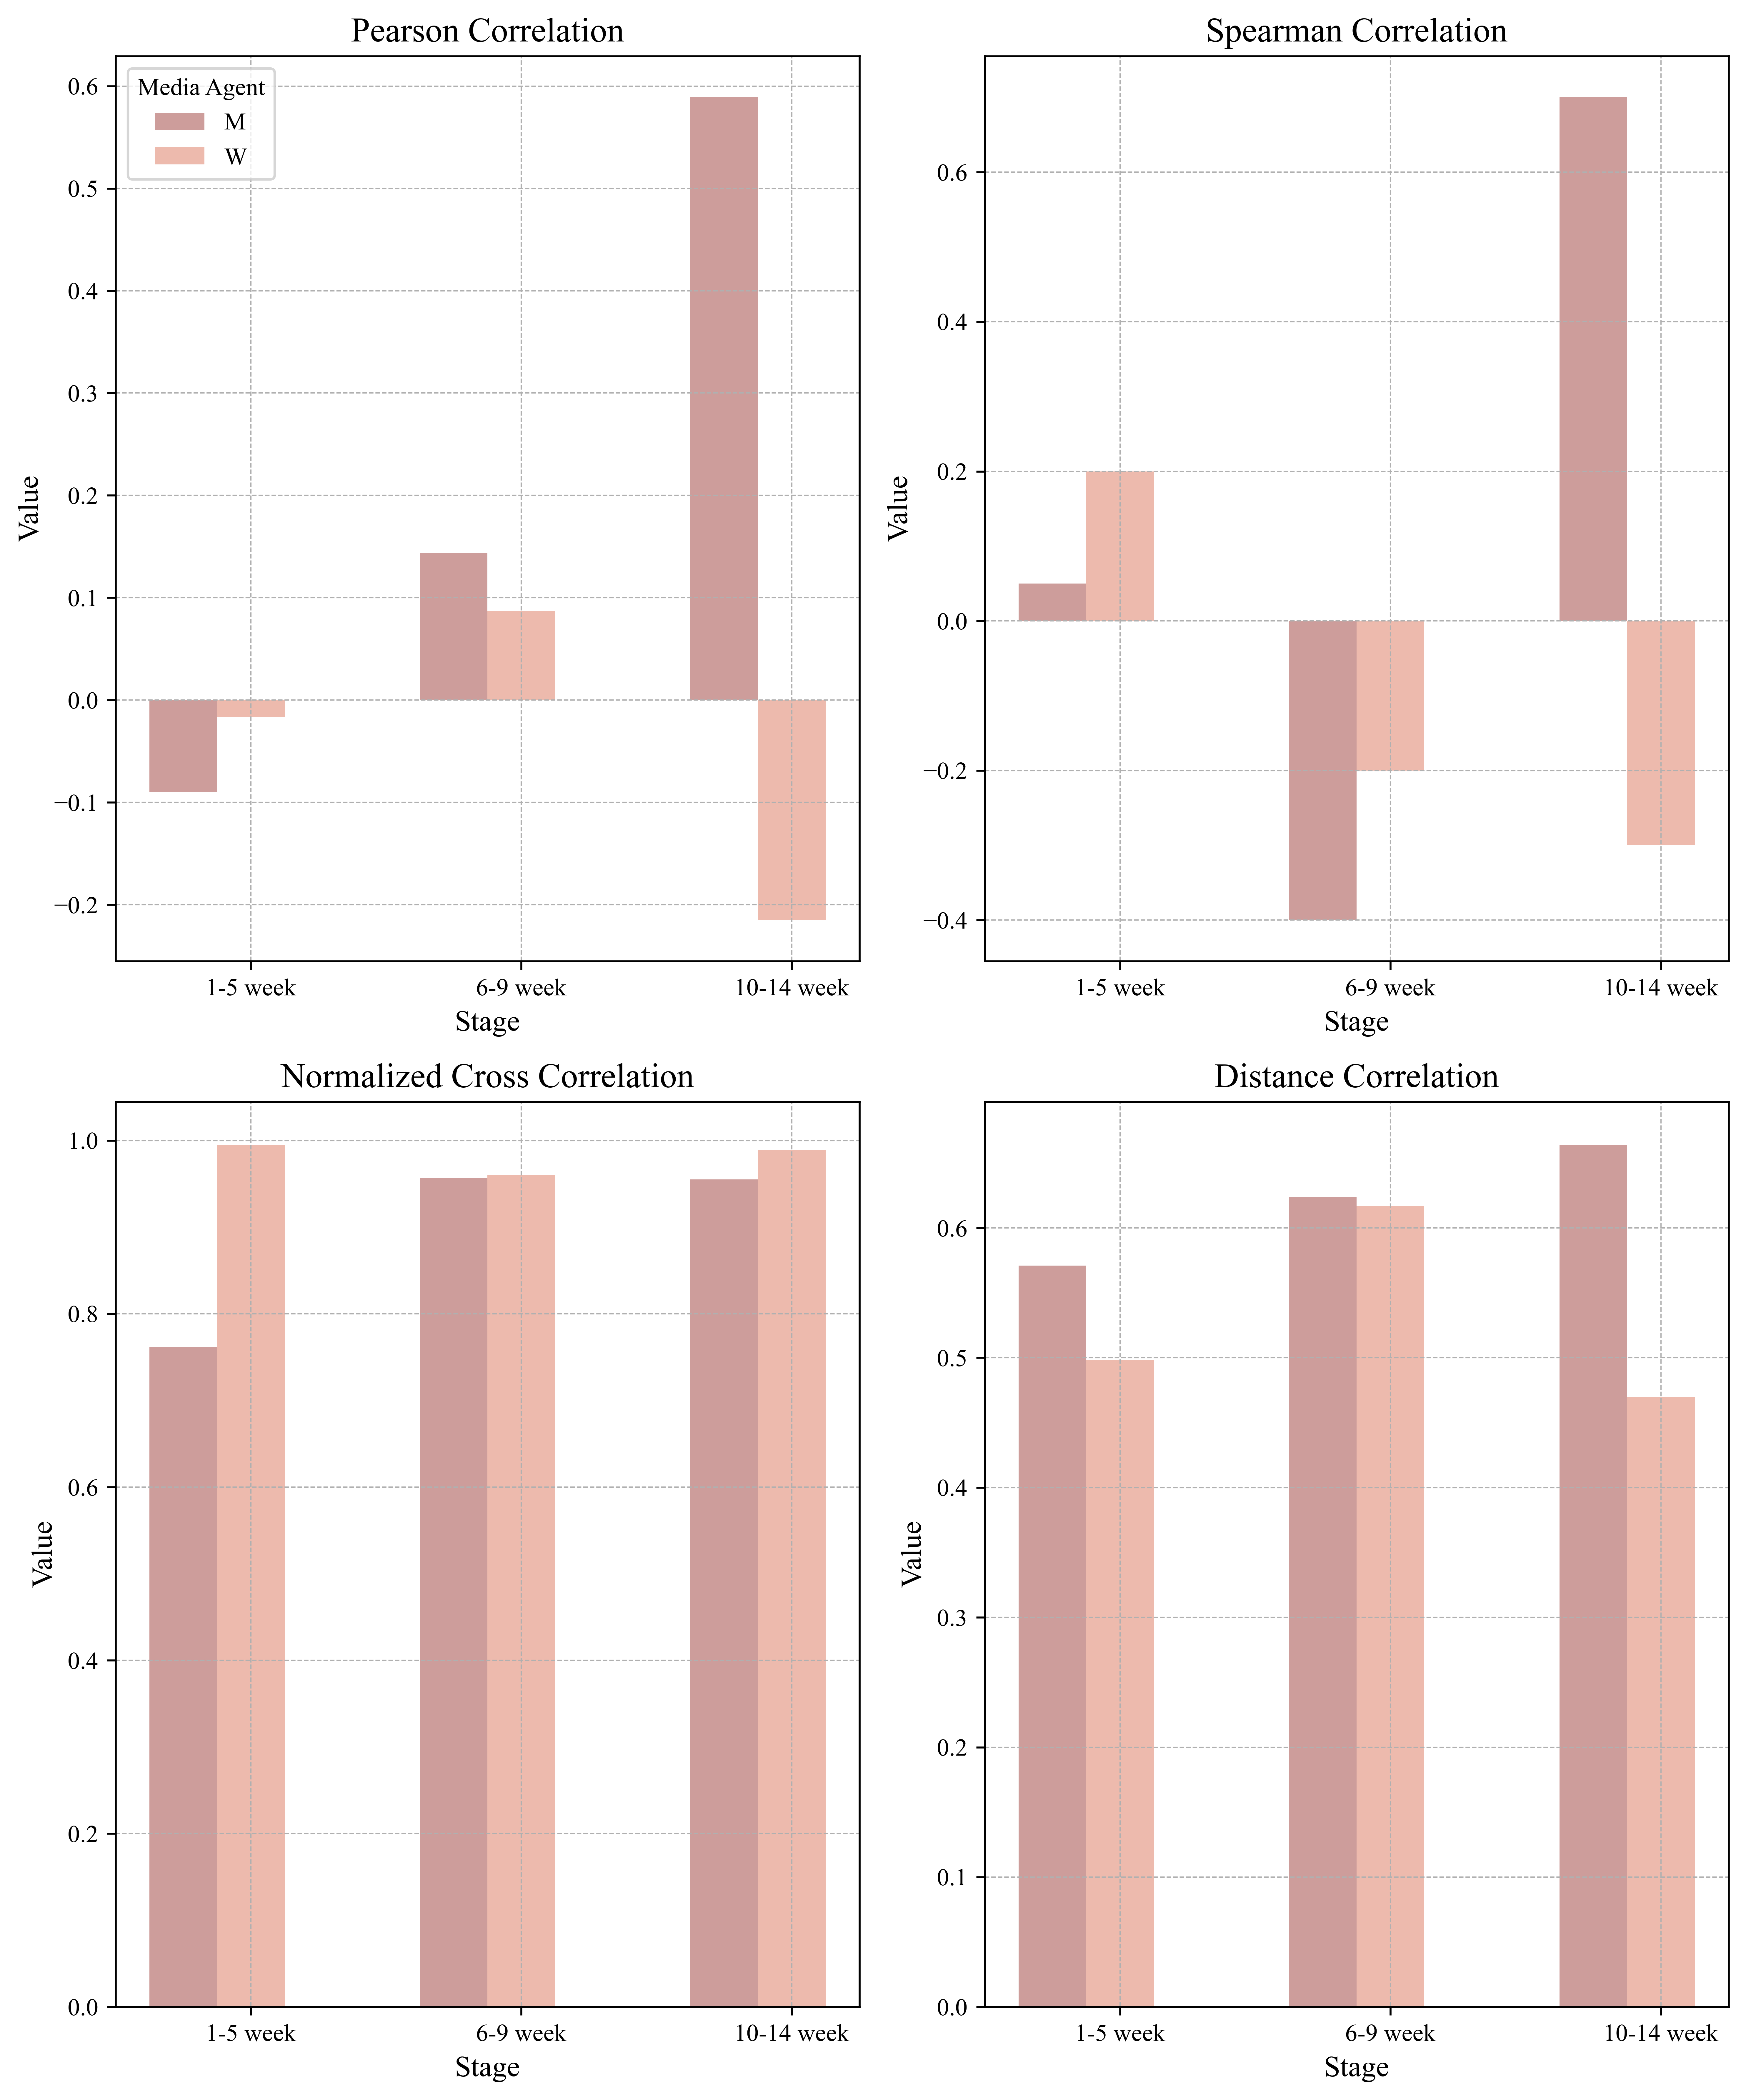

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# 新数据
stages = ['1-5 week', '6-9 week', '10-14 week']
agents = ['M', 'W']
metrics = ['Pearson', 'Spearman', 'Normalized Cross', 'Distance']

data = {
    'M': {
        'Pearson': [-0.090, 0.144, 0.589],
        'Spearman': [0.05, -0.4, 0.7],
        'Normalized Cross': [0.762, 0.957, 0.955],
        'Distance': [0.571, 0.624, 0.664]
    },
    'W': {
        'Pearson': [-0.017, 0.087, -0.215],
        'Spearman': [0.2, -0.2, -0.3],
        'Normalized Cross': [0.995, 0.960, 0.989],
        'Distance': [0.498, 0.617, 0.470]
    }
}

# 设置字体为 Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

# 配色方案
colors = ['#C89290', '#EBB3A4']  # M和W的颜色

# 创建子图
fig, axes = plt.subplots(2, 2, figsize=(10, 12), dpi=600)
axes = axes.flatten()

# 绘制每个metric的柱状图
bar_width = 0.25
x = np.arange(len(stages))  # 横轴位置

for i, metric in enumerate(metrics):
    ax = axes[i]
    
    # 绘制每个 Media Agent 的数据
    for j, agent in enumerate(agents):
        ax.bar(x + j * bar_width, data[agent][metric], width=bar_width, label=agent, color=colors[j], alpha=0.9)
    
    # 设置子图标题、轴标签、刻度
    ax.set_title(metric + ' Correlation', fontsize=14)
    ax.set_xlabel('Stage', fontsize=12)
    ax.set_ylabel('Value', fontsize=12)
    ax.set_xticks(x + bar_width)
    ax.set_xticklabels(stages)
    
    # 仅保留第一个子图的图例
    if i == 0:
        ax.legend(title='Media Agent')
    else:
        if ax.get_legend() is not None:
            ax.get_legend().remove()

    # 添加网格
    ax.grid(True, linestyle='--', linewidth=0.5)

# 调整布局
plt.tight_layout()
plt.savefig('graph/media_metric.png', dpi=600)

# 显示图形
plt.show()


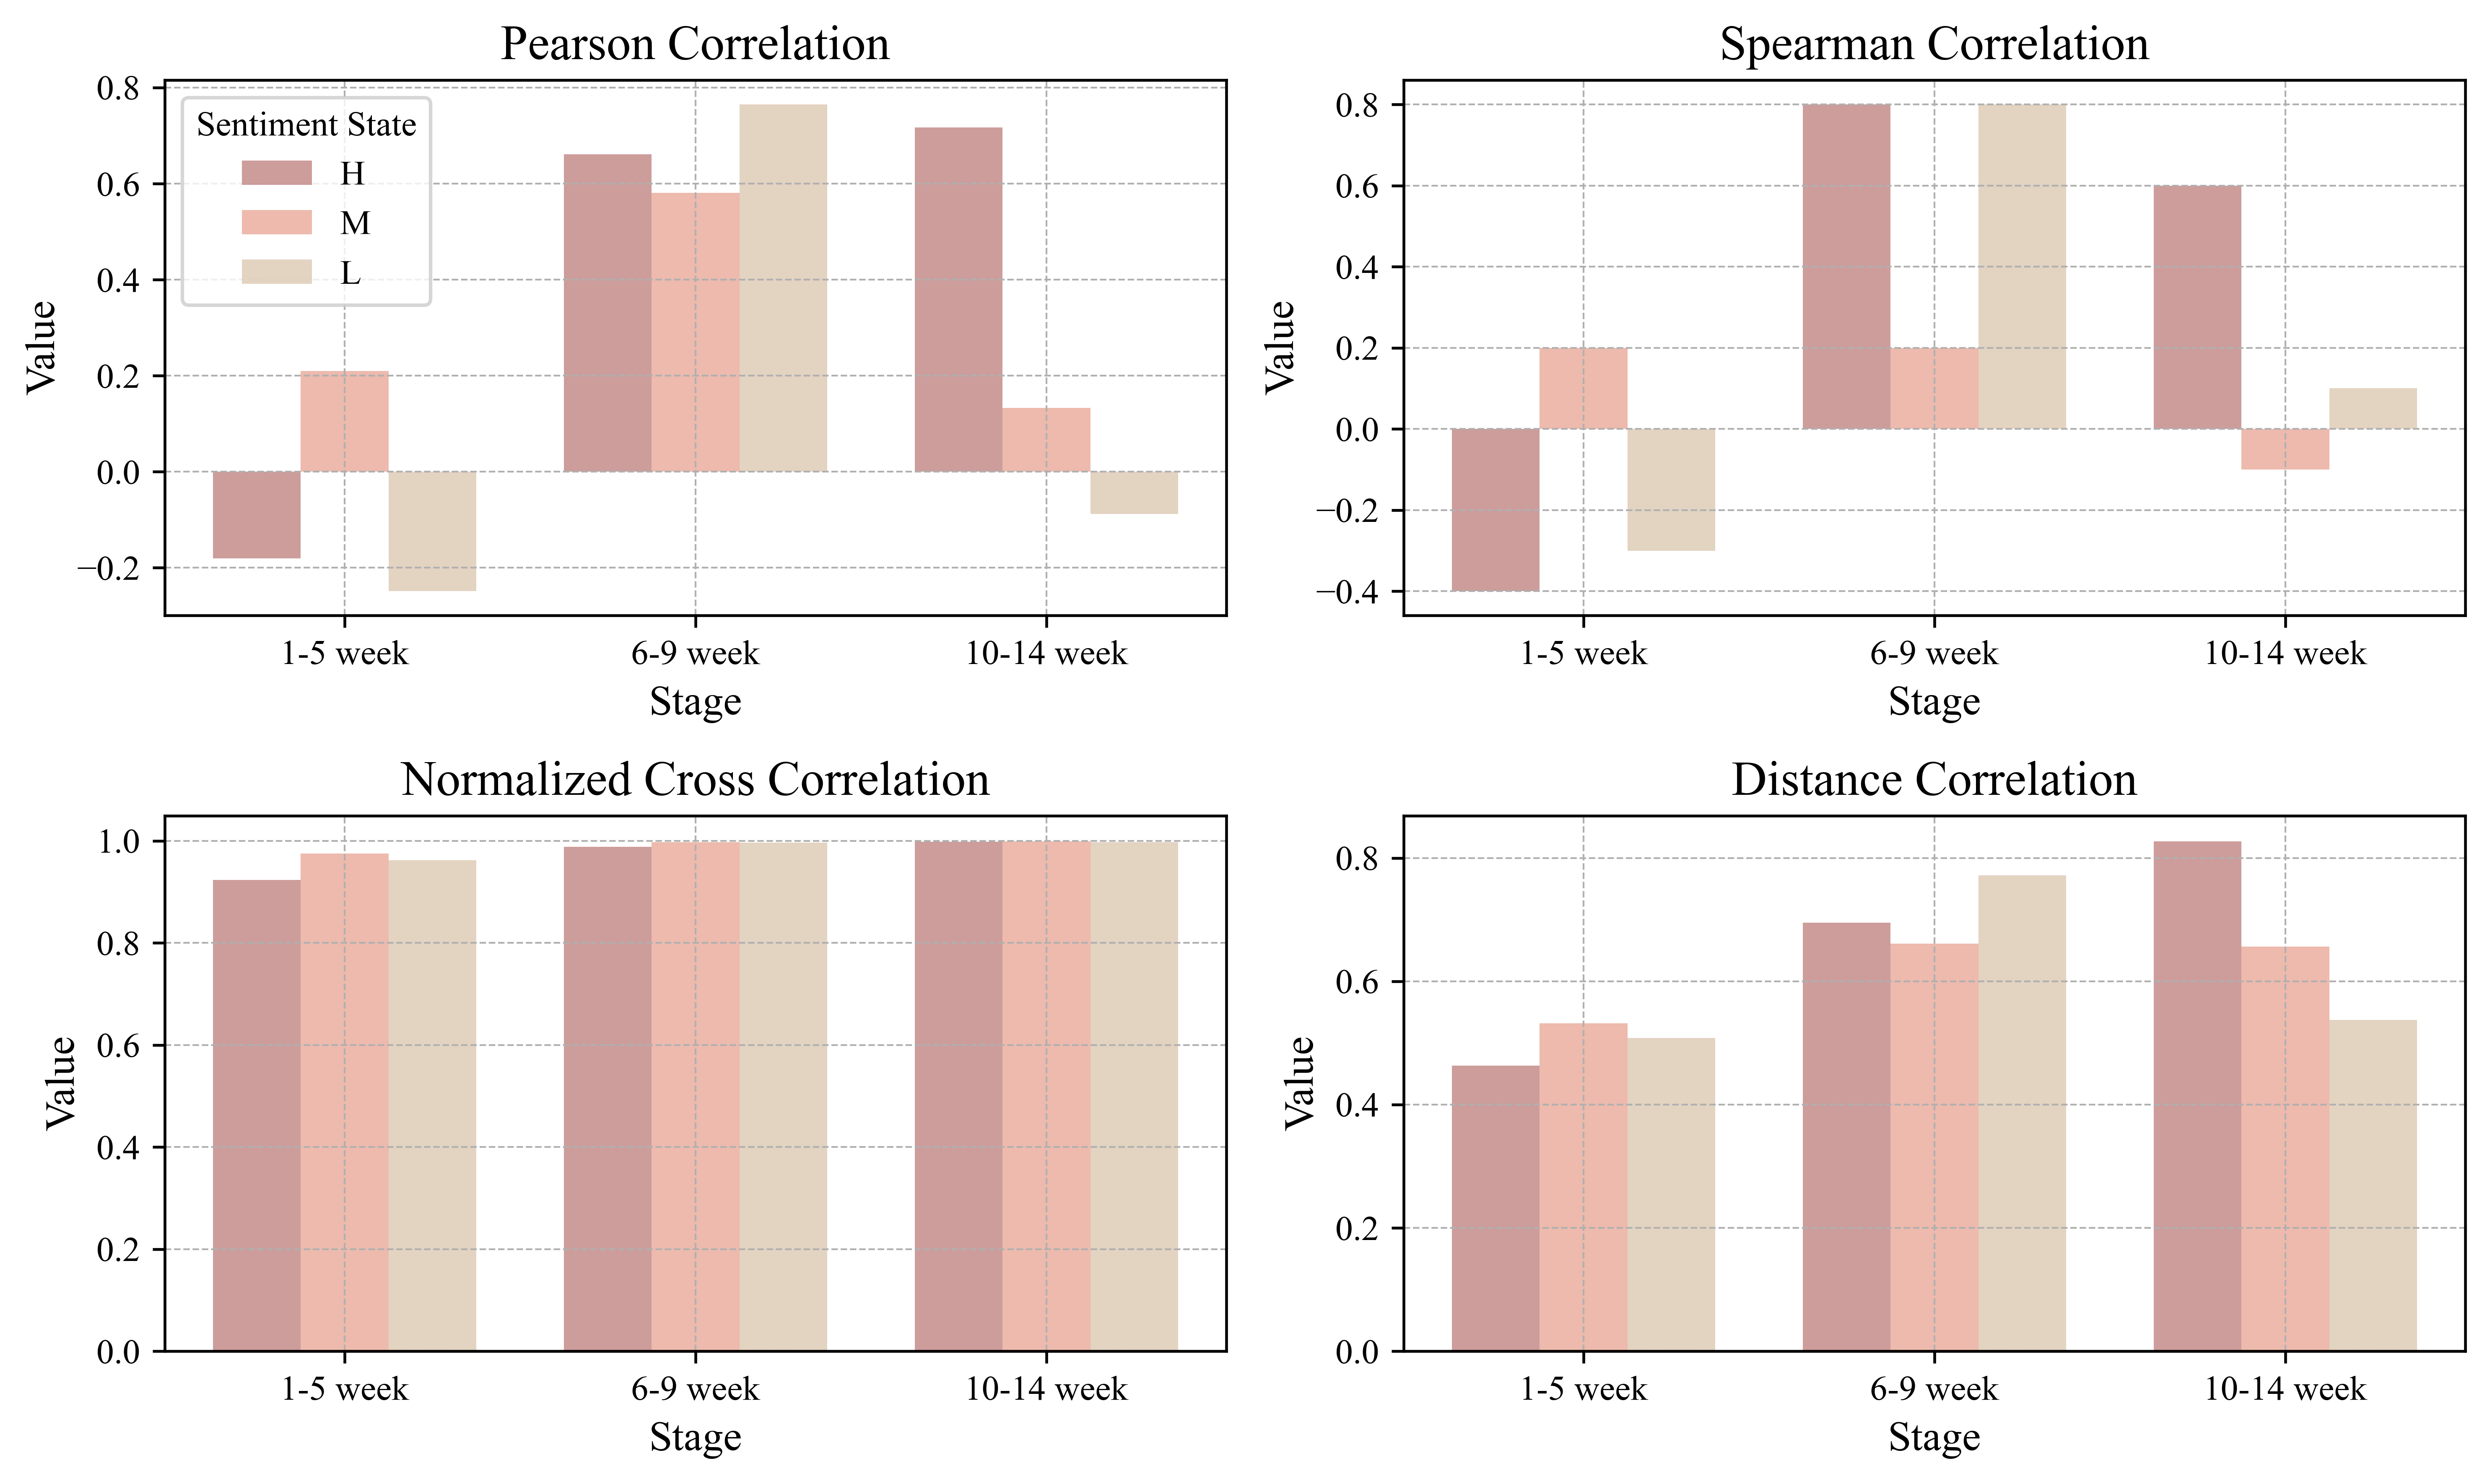

In [24]:
# 修改代码以仅保留第一个子图的图例，其他子图移除图例

import numpy as np
import matplotlib.pyplot as plt

# 数据
stages = ['1-5 week', '6-9 week', '10-14 week']
states = ['H', 'M', 'L']
metrics = ['Pearson', 'Spearman', 'Normalized Cross', 'Distance']

data = {
    'H': {
        'Pearson': [-0.181, 0.661, 0.717],
        'Spearman': [-0.4, 0.8, 0.6],
        'Normalized Cross': [0.923, 0.988, 0.998],
        'Distance': [0.463, 0.695, 0.827]
    },
    'M': {
        'Pearson': [0.210, 0.581, 0.133],
        'Spearman': [0.2, 0.2, -0.1],
        'Normalized Cross': [0.975, 0.997, 0.999],
        'Distance': [0.532, 0.661, 0.656]
    },
    'L': {
        'Pearson': [-0.249, 0.765, -0.088],
        'Spearman': [-0.3, 0.8, 0.1],
        'Normalized Cross': [0.962, 0.996, 0.997],
        'Distance': [0.508, 0.772, 0.537]
    }
}

# 设置字体为 Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

# 新的配色方案，参考上传的图片
colors = ['#C89290', '#EBB3A4', '#E0CFBB', '#C4B1A2']  # 新的学术风格配色方案

# 创建子图
fig, axes = plt.subplots(2, 2, figsize=(10, 6), dpi=600)
axes = axes.flatten()

# 绘制每个metric的柱状图
bar_width = 0.25
x = np.arange(len(stages))  # 横轴位置

for i, metric in enumerate(metrics):
    ax = axes[i]
    
    # 绘制每个 sentiment state 的数据
    for j, state in enumerate(states):
        ax.bar(x + j * bar_width, data[state][metric], width=bar_width, label=state, color=colors[j], alpha=0.9)
    
    # 设置子图标题、轴标签、刻度
    ax.set_title(metric + ' Correlation', fontsize=14)
    ax.set_xlabel('Stage', fontsize=12)
    ax.set_ylabel('Value', fontsize=12)
    ax.set_xticks(x + bar_width)
    ax.set_xticklabels(stages)
    
    # 仅保留第一个子图的图例
    if i == 0:
        ax.legend(title='Sentiment State')
    else:
        # 只有存在图例时才移除
        if ax.get_legend() is not None:
            ax.get_legend().remove()

    # 添加网格
    ax.grid(True, linestyle='--', linewidth=0.5)

# 调整布局
plt.tight_layout()
plt.savefig('graph/metrics.png', dpi=600)

# 显示图形
plt.show()


In [1]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
graph_data = joblib.load('./new_output/graph_data.pkl')
weeks_in_simulation = 14  # 根据实际数据调整
samples_per_week = 7
simulation_data = graph_data['simulation_data_W_R']
empirical_data = graph_data['empirical_data_W_R']

In [2]:
simulation_data_h = graph_data['simulation_data_h']
simulation_data_m = graph_data['simulation_data_m']
simulation_data_l = graph_data['simulation_data_l']
simulation_data_M_R = graph_data['simulation_data_M_R']
simulation_data_W_R = graph_data['simulation_data_W_R']

In [7]:
# 计算主流媒体的风险向量和公众情绪向量之间的相关性
from scipy.stats import pearsonr, spearmanr
print('sentiment_high和m_media_risk的相关性：')
print('Pearson:', pearsonr(simulation_data_h, simulation_data_M_R)[0], '显著度:', pearsonr(simulation_data_h, simulation_data_M_R)[1])
print('Spearman:', spearmanr(simulation_data_h, simulation_data_M_R)[0], '显著度:', spearmanr(simulation_data_h, simulation_data_M_R)[1])
print('-'*50)

print('sentiment_middle和m_media_risk的相关性：')
print('Pearson:', pearsonr(simulation_data_m, simulation_data_M_R)[0], '显著度:', pearsonr(simulation_data_m, simulation_data_M_R)[1])
print('Spearman:', spearmanr(simulation_data_m, simulation_data_M_R)[0], '显著度:', spearmanr(simulation_data_m, simulation_data_M_R)[1])
print('-'*50)

print('sentiment_low和m_media_risk的相关性：')
print('Pearson:', pearsonr(simulation_data_l, simulation_data_M_R)[0], '显著度:', pearsonr(simulation_data_l, simulation_data_M_R)[1])
print('Spearman:', spearmanr(simulation_data_l, simulation_data_M_R)[0], '显著度:', spearmanr(simulation_data_l, simulation_data_M_R)[1])

sentiment_high和m_media_risk的相关性：
Pearson: 0.848437555809787 显著度: 1.499161581894005e-28
Spearman: 0.7606925248797771 显著度: 6.578342841063231e-20
--------------------------------------------------
sentiment_middle和m_media_risk的相关性：
Pearson: -0.3848900916713061 显著度: 8.36716893562667e-05
Spearman: -0.06211214106711302 显著度: 0.541365563767568
--------------------------------------------------
sentiment_low和m_media_risk的相关性：
Pearson: -0.7884185956682468 显著度: 3.455096388118742e-22
Spearman: -0.7208685669784288 显著度: 3.991168285453945e-17


In [11]:
# 计算自媒体的风险向量和公众情绪向量之间的相关性
from scipy.stats import pearsonr, spearmanr
print('sentiment_high和w_media_risk的相关性：')
print('Pearson:', pearsonr(simulation_data_h, simulation_data_W_R)[0], '显著度:', pearsonr(simulation_data_h, simulation_data_W_R)[1])
print('Spearman:', spearmanr(simulation_data_h, simulation_data_W_R)[0], '显著度:', spearmanr(simulation_data_h, simulation_data_W_R)[1])
print('-'*50)

print('sentiment_middle和w_media_risk的相关性：')
print('Pearson:', pearsonr(simulation_data_m, simulation_data_W_R)[0], '显著度:', pearsonr(simulation_data_m, simulation_data_W_R)[1])
print('Spearman:', spearmanr(simulation_data_m, simulation_data_W_R)[0], '显著度:', spearmanr(simulation_data_m, simulation_data_W_R)[1])
print('-'*50)

print('sentiment_low和w_media_risk的相关性：')
print('Pearson:', pearsonr(simulation_data_l, simulation_data_W_R)[0], '显著度:', pearsonr(simulation_data_l, simulation_data_W_R)[1])
print('Spearman:', spearmanr(simulation_data_l, simulation_data_W_R)[0], '显著度:', spearmanr(simulation_data_l, simulation_data_W_R)[1])

sentiment_high和w_media_risk的相关性：
Pearson: -0.06775137019791676 显著度: 0.5052050433369378
Spearman: 0.1972485353498508 显著度: 0.05035401193149816
--------------------------------------------------
sentiment_middle和w_media_risk的相关性：
Pearson: 0.7403901835855281 显著度: 1.996937188100695e-18
Spearman: 0.2959259501393583 显著度: 0.002939999850171452
--------------------------------------------------
sentiment_low和w_media_risk的相关性：
Pearson: -0.09500719069833426 显著度: 0.34957080882439495
Spearman: -0.2622796762985632 显著度: 0.008726468157895493


In [ ]:
figsize = (10, 6)  # 统一的画框大小

<Figure size 1920x1440 with 0 Axes>

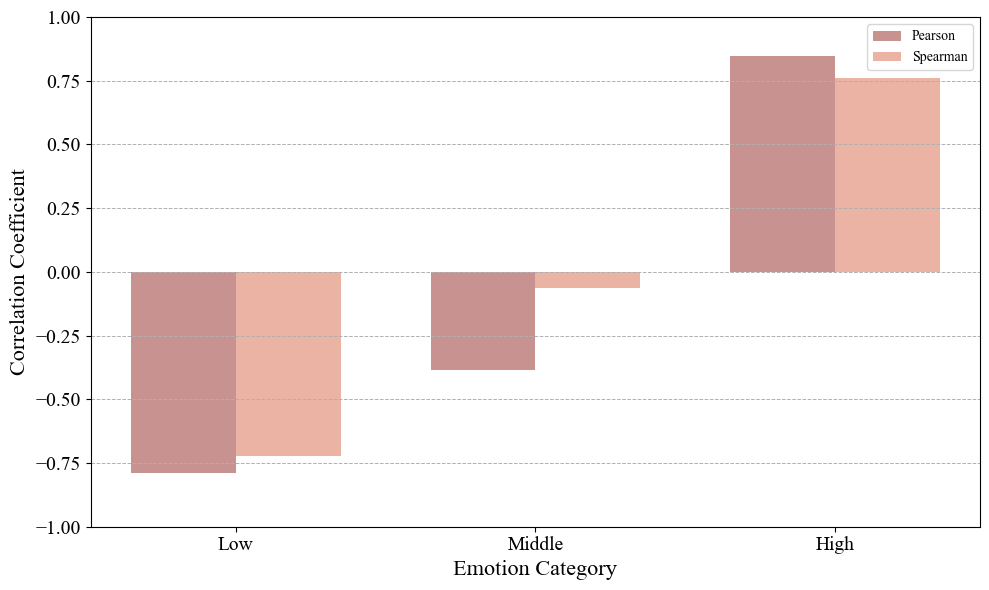

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# 数据
categories = ['Low', 'Middle', 'High']
pearson_values = [-0.7884, -0.3849, 0.8484]
spearman_values = [-0.7209, -0.0621, 0.7607]

# 设置图像 DPI 和字体
plt.figure(dpi=300)
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

# 定义柱状图的宽度
bar_width = 0.35
index = np.arange(len(categories))

# 颜色方案
colors = ['#C89290', '#EBB3A4']

# 创建柱状图
fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(index, pearson_values, bar_width, label='Pearson', color=colors[0])
bar2 = ax.bar(index + bar_width, spearman_values, bar_width, label='Spearman', color=colors[1])

# 添加标签和标题
ax.set_xlabel('Emotion Category')
ax.set_ylabel('Correlation Coefficient')
# ax.set_title('Correlation Between Sentiment and Mainstream Media Risk')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(categories)
ax.legend()

# 设置Y轴范围和网格线
ax.set_ylim([-1, 1])
ax.grid(True, which='major', axis='y', linestyle='--', linewidth=0.7)

# 保存图片
plt.tight_layout()
plt.savefig('graph/correlation_chart_m_media_risk.png', dpi=600)

plt.show()


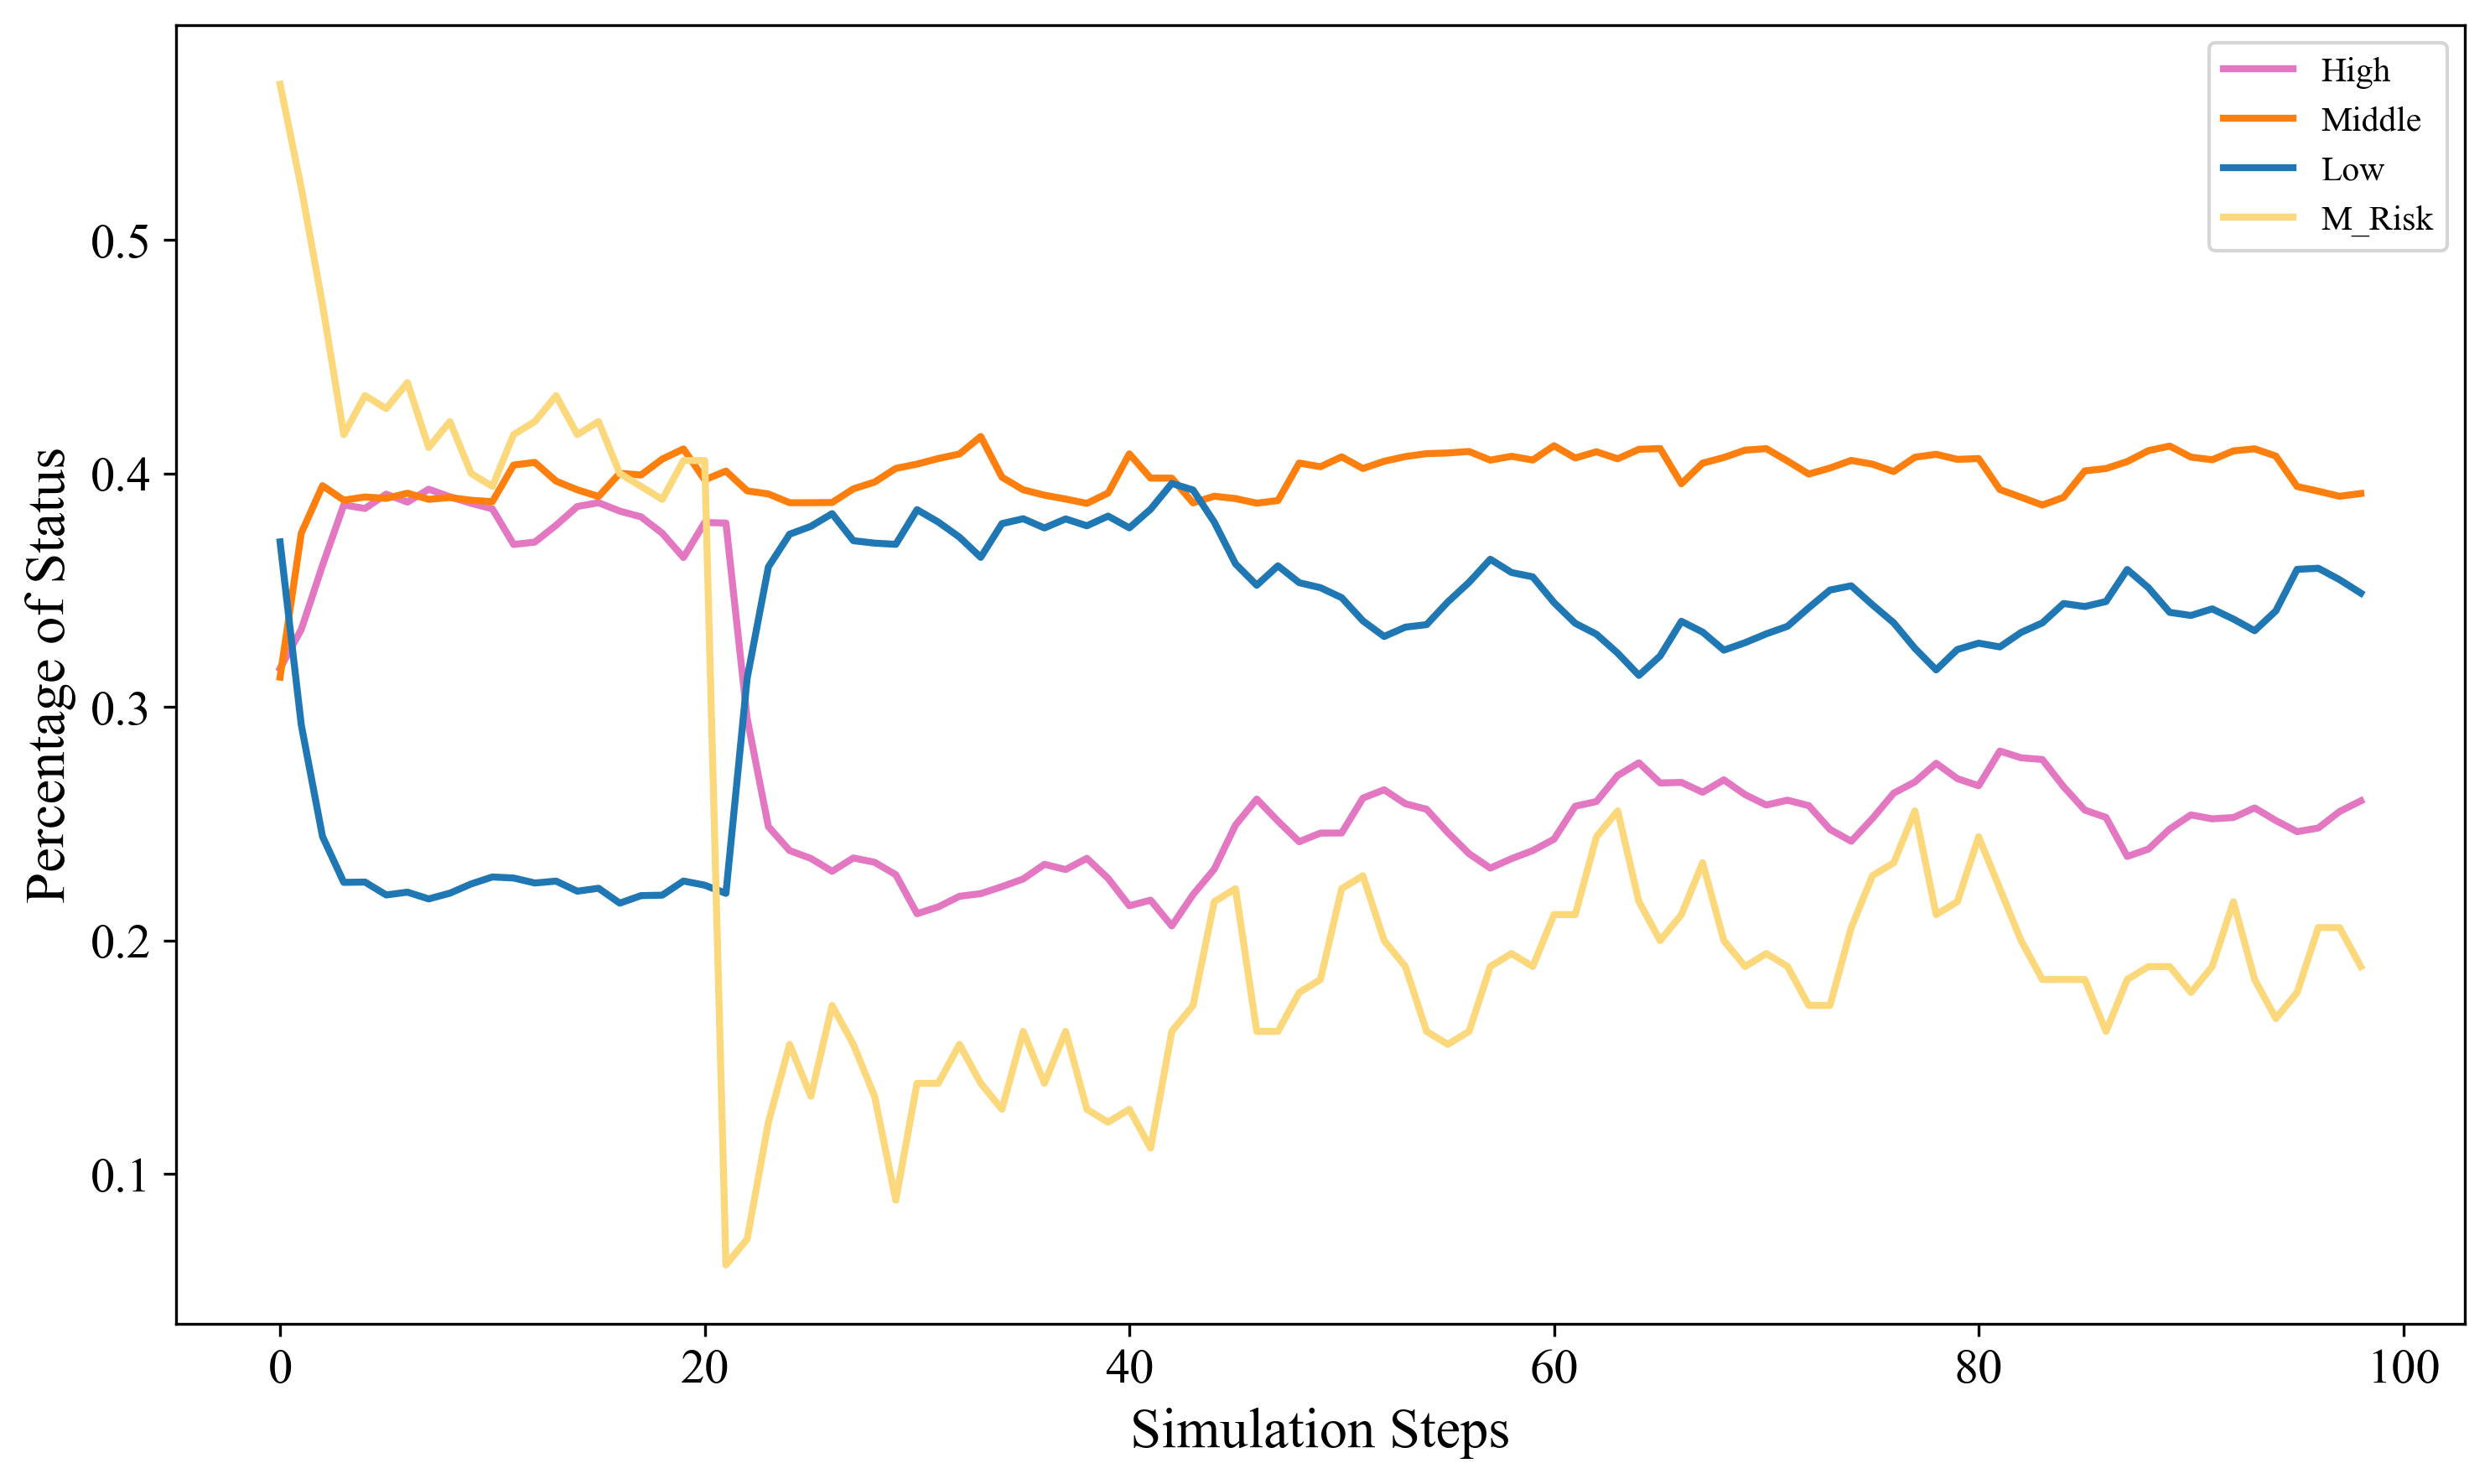

In [3]:
# 设置配色
colors = ['#E377C2', '#ff7f0e', '#1f77b4', '#FBD87C']
x = np.arange(len(simulation_data_h))
# 创建折线图
plt.figure(dpi=300, figsize=(10, 6))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

# 绘制每条折线
plt.plot(x, simulation_data_h, label='High', color=colors[0], linewidth=2)
plt.plot(x, simulation_data_m, label='Middle', color=colors[1], linewidth=2)
plt.plot(x, simulation_data_l, label='Low', color=colors[2], linewidth=2)
plt.plot(x, simulation_data_M_R, label='M_Risk', color=colors[3], linewidth=2)

# 添加标签和标题
plt.xlabel('Simulation Steps')
plt.ylabel('Percentage of Status')
# plt.title('Simulation Data Trends')

# 添加图例
plt.legend()

# 保存图片
plt.tight_layout()
plt.savefig('graph/m_media_sentiment_line.png', dpi=600)

# 展示图片
plt.show()

<Figure size 3840x2880 with 0 Axes>

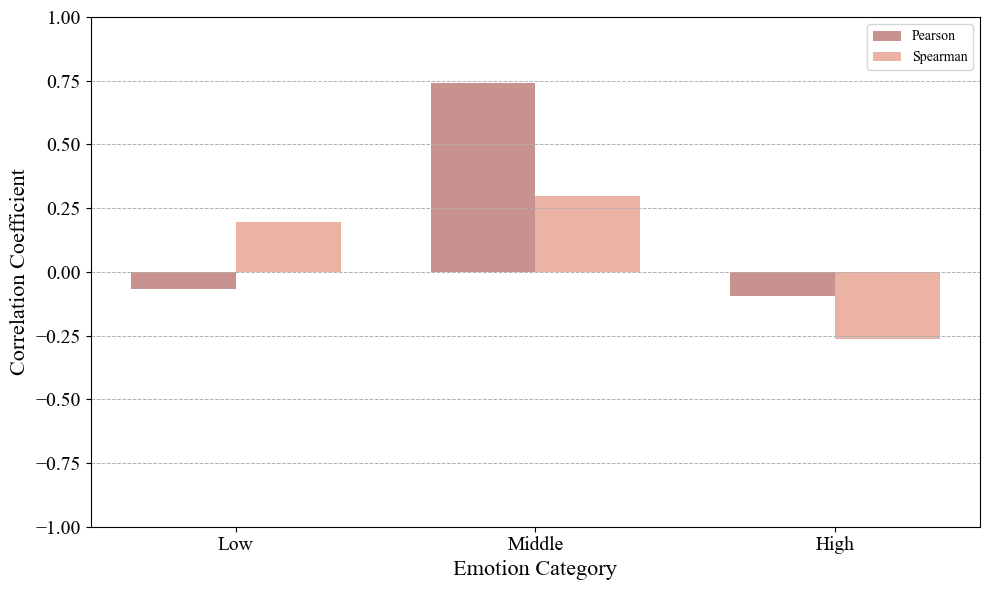

In [49]:
# 新的数据
pearson_values_w = [-0.0678, 0.7404, -0.0950]
spearman_values_w = [0.1972, 0.2959, -0.2623]

# 创建新的柱状图
plt.figure(dpi=600)
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
colors = ['#C89290', '#EBB3A4']
# 定义柱状图的宽度
bar_width = 0.35
index = np.arange(len(categories))

# 创建柱状图
fig, ax = plt.subplots(figsize=(10, 6))
bar1_w = ax.bar(index, pearson_values_w, bar_width, label='Pearson', color=colors[0])
bar2_w = ax.bar(index + bar_width, spearman_values_w, bar_width, label='Spearman', color=colors[1])

# 添加标签和标题
ax.set_xlabel('Emotion Category')
ax.set_ylabel('Correlation Coefficient')
# ax.set_title('Correlation Between Sentiment and We Media Risk')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(categories)
ax.legend()

# 设置Y轴范围和网格线
ax.set_ylim([-1, 1])
ax.grid(True, which='major', axis='y', linestyle='--', linewidth=0.7)

# 保存图片
plt.tight_layout()
plt.savefig('graph/correlation_chart_w_media_risk.png', dpi=600)

plt.show()


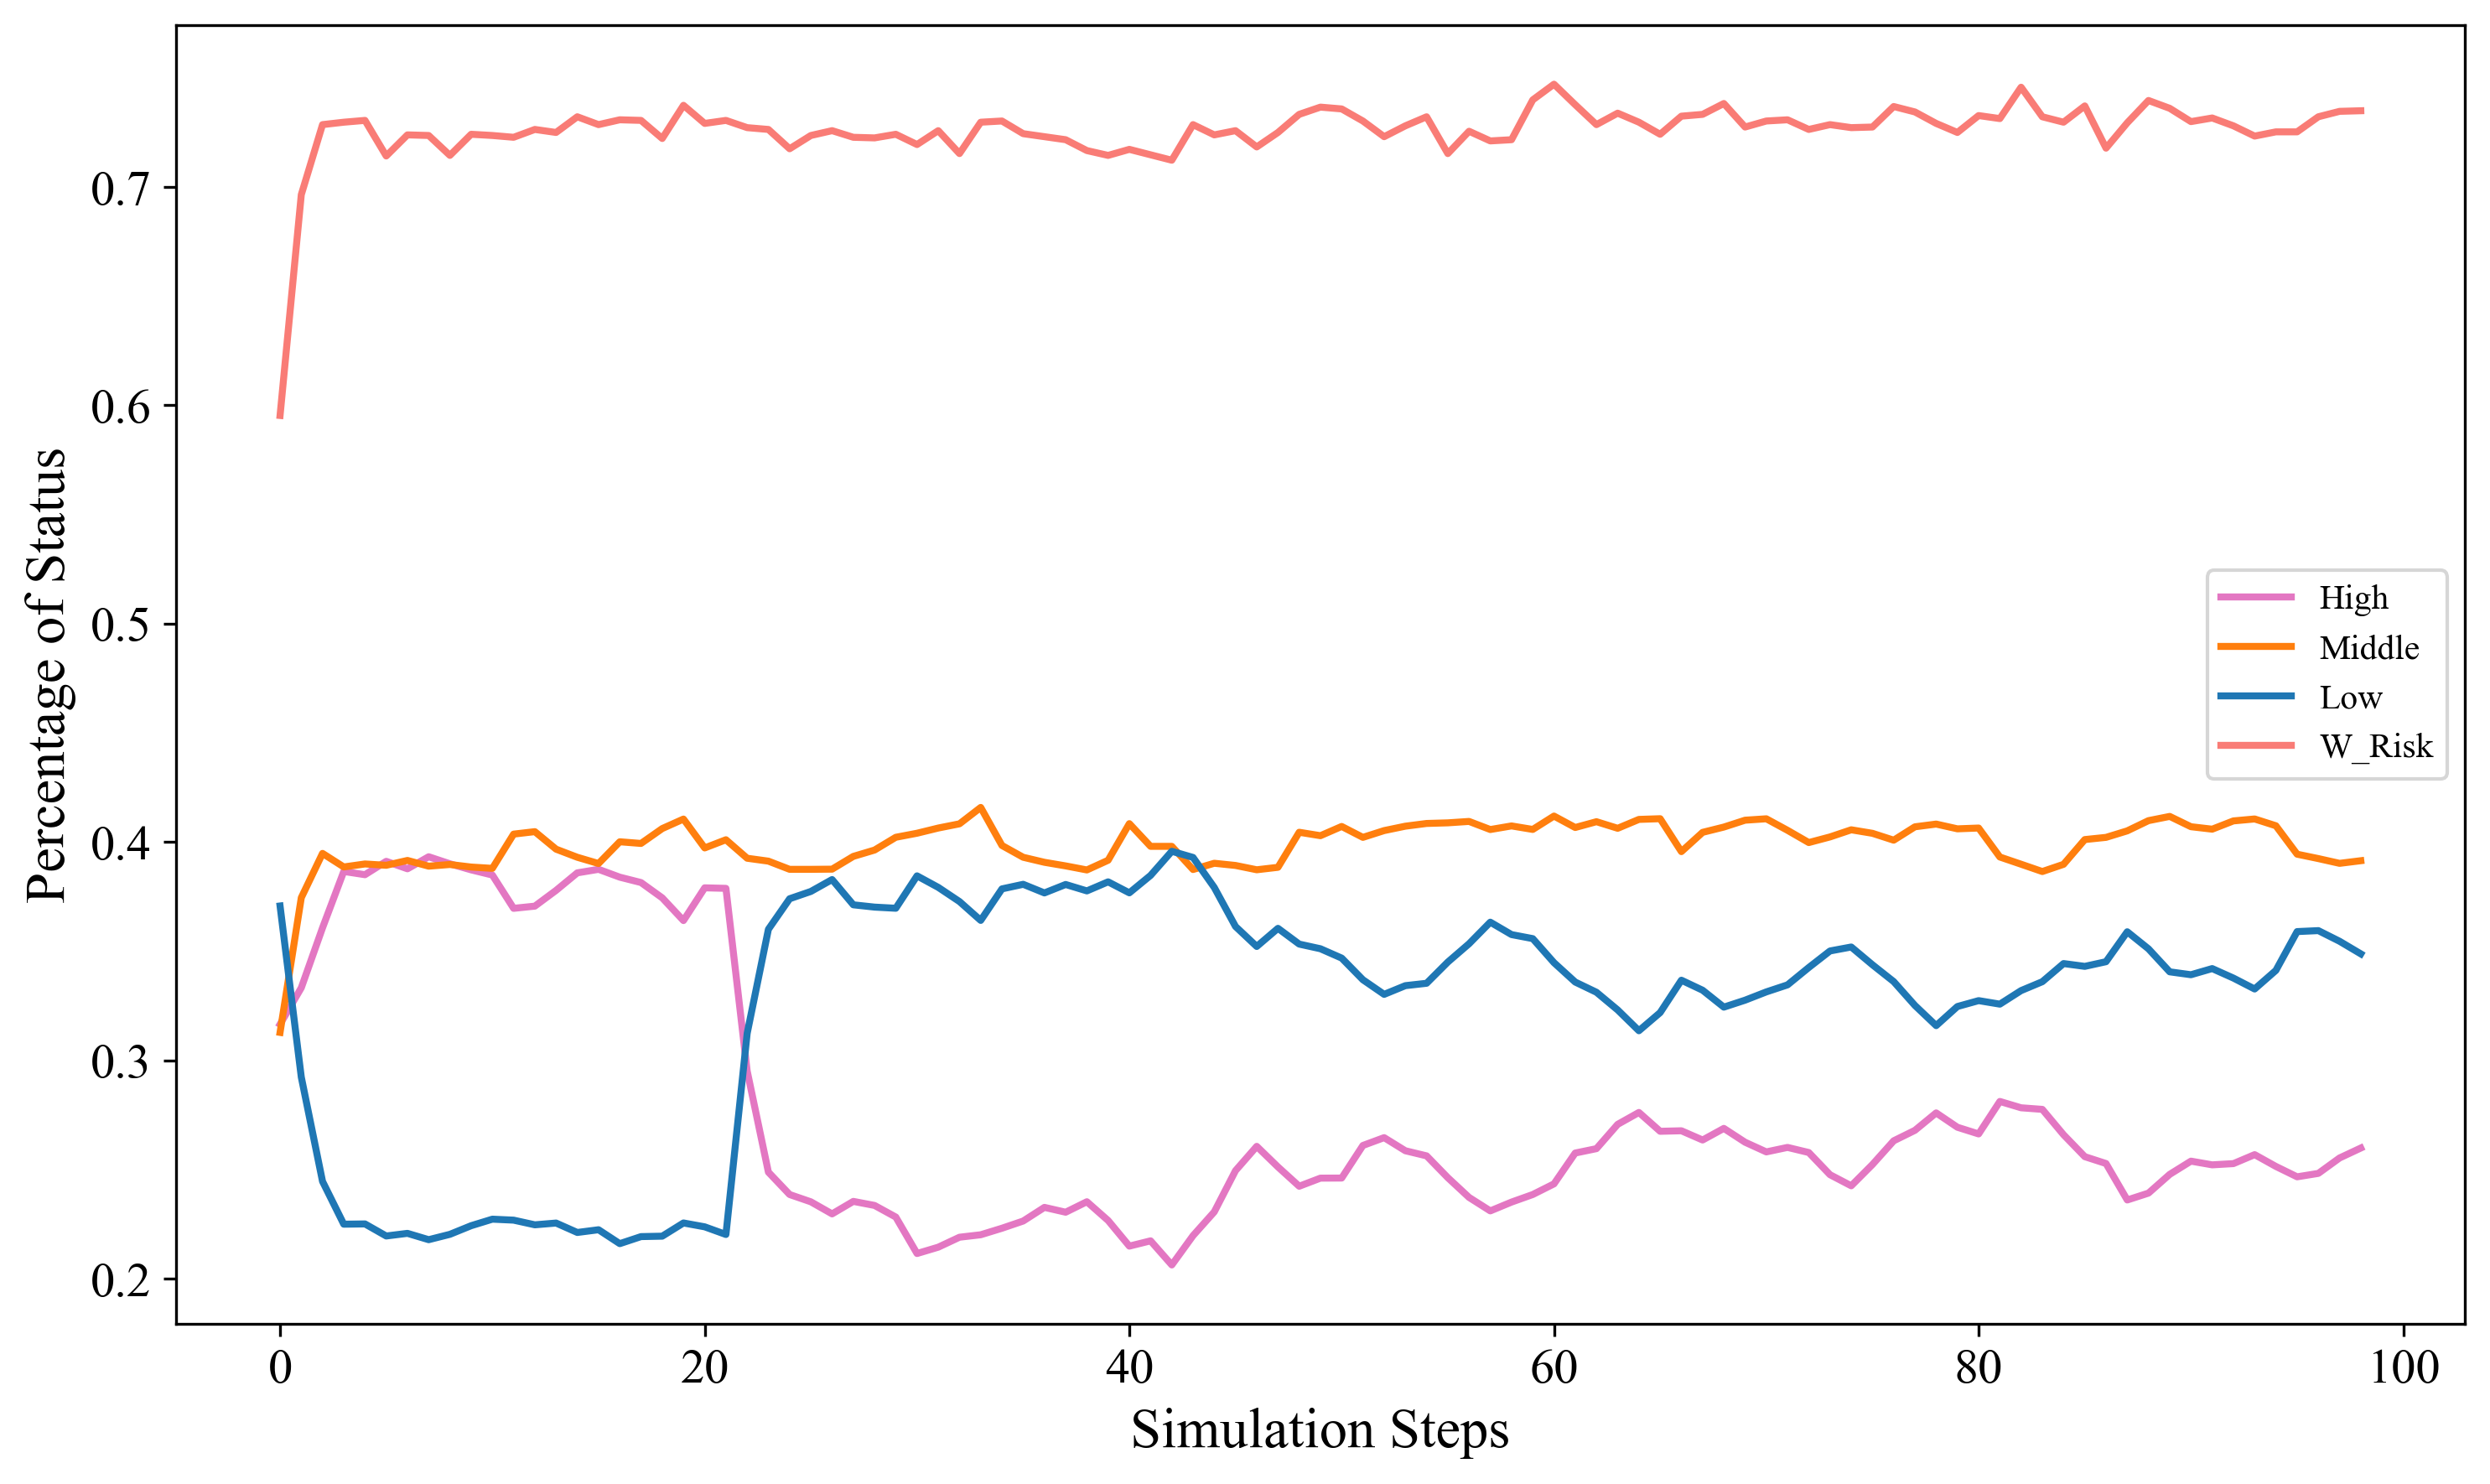

In [4]:
# 设置配色
colors = ['#E377C2', '#ff7f0e', '#1f77b4', '#F97C76']
x = np.arange(len(simulation_data_h))
# 创建折线图
plt.figure(dpi=300, figsize=(10, 6))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

# 绘制每条折线
plt.plot(x, simulation_data_h, label='High', color=colors[0], linewidth=2)
plt.plot(x, simulation_data_m, label='Middle', color=colors[1], linewidth=2)
plt.plot(x, simulation_data_l, label='Low', color=colors[2], linewidth=2)
plt.plot(x, simulation_data_W_R, label='W_Risk', color=colors[3], linewidth=2)

# 添加标签和标题
plt.xlabel('Simulation Steps')
plt.ylabel('Percentage of Status')
# plt.title('Simulation Data Trends')

# 添加图例
plt.legend()

# 保存图片
plt.tight_layout()
plt.savefig('graph/w_media_sentiment_line.png', dpi=600)

# 展示图片
plt.show()

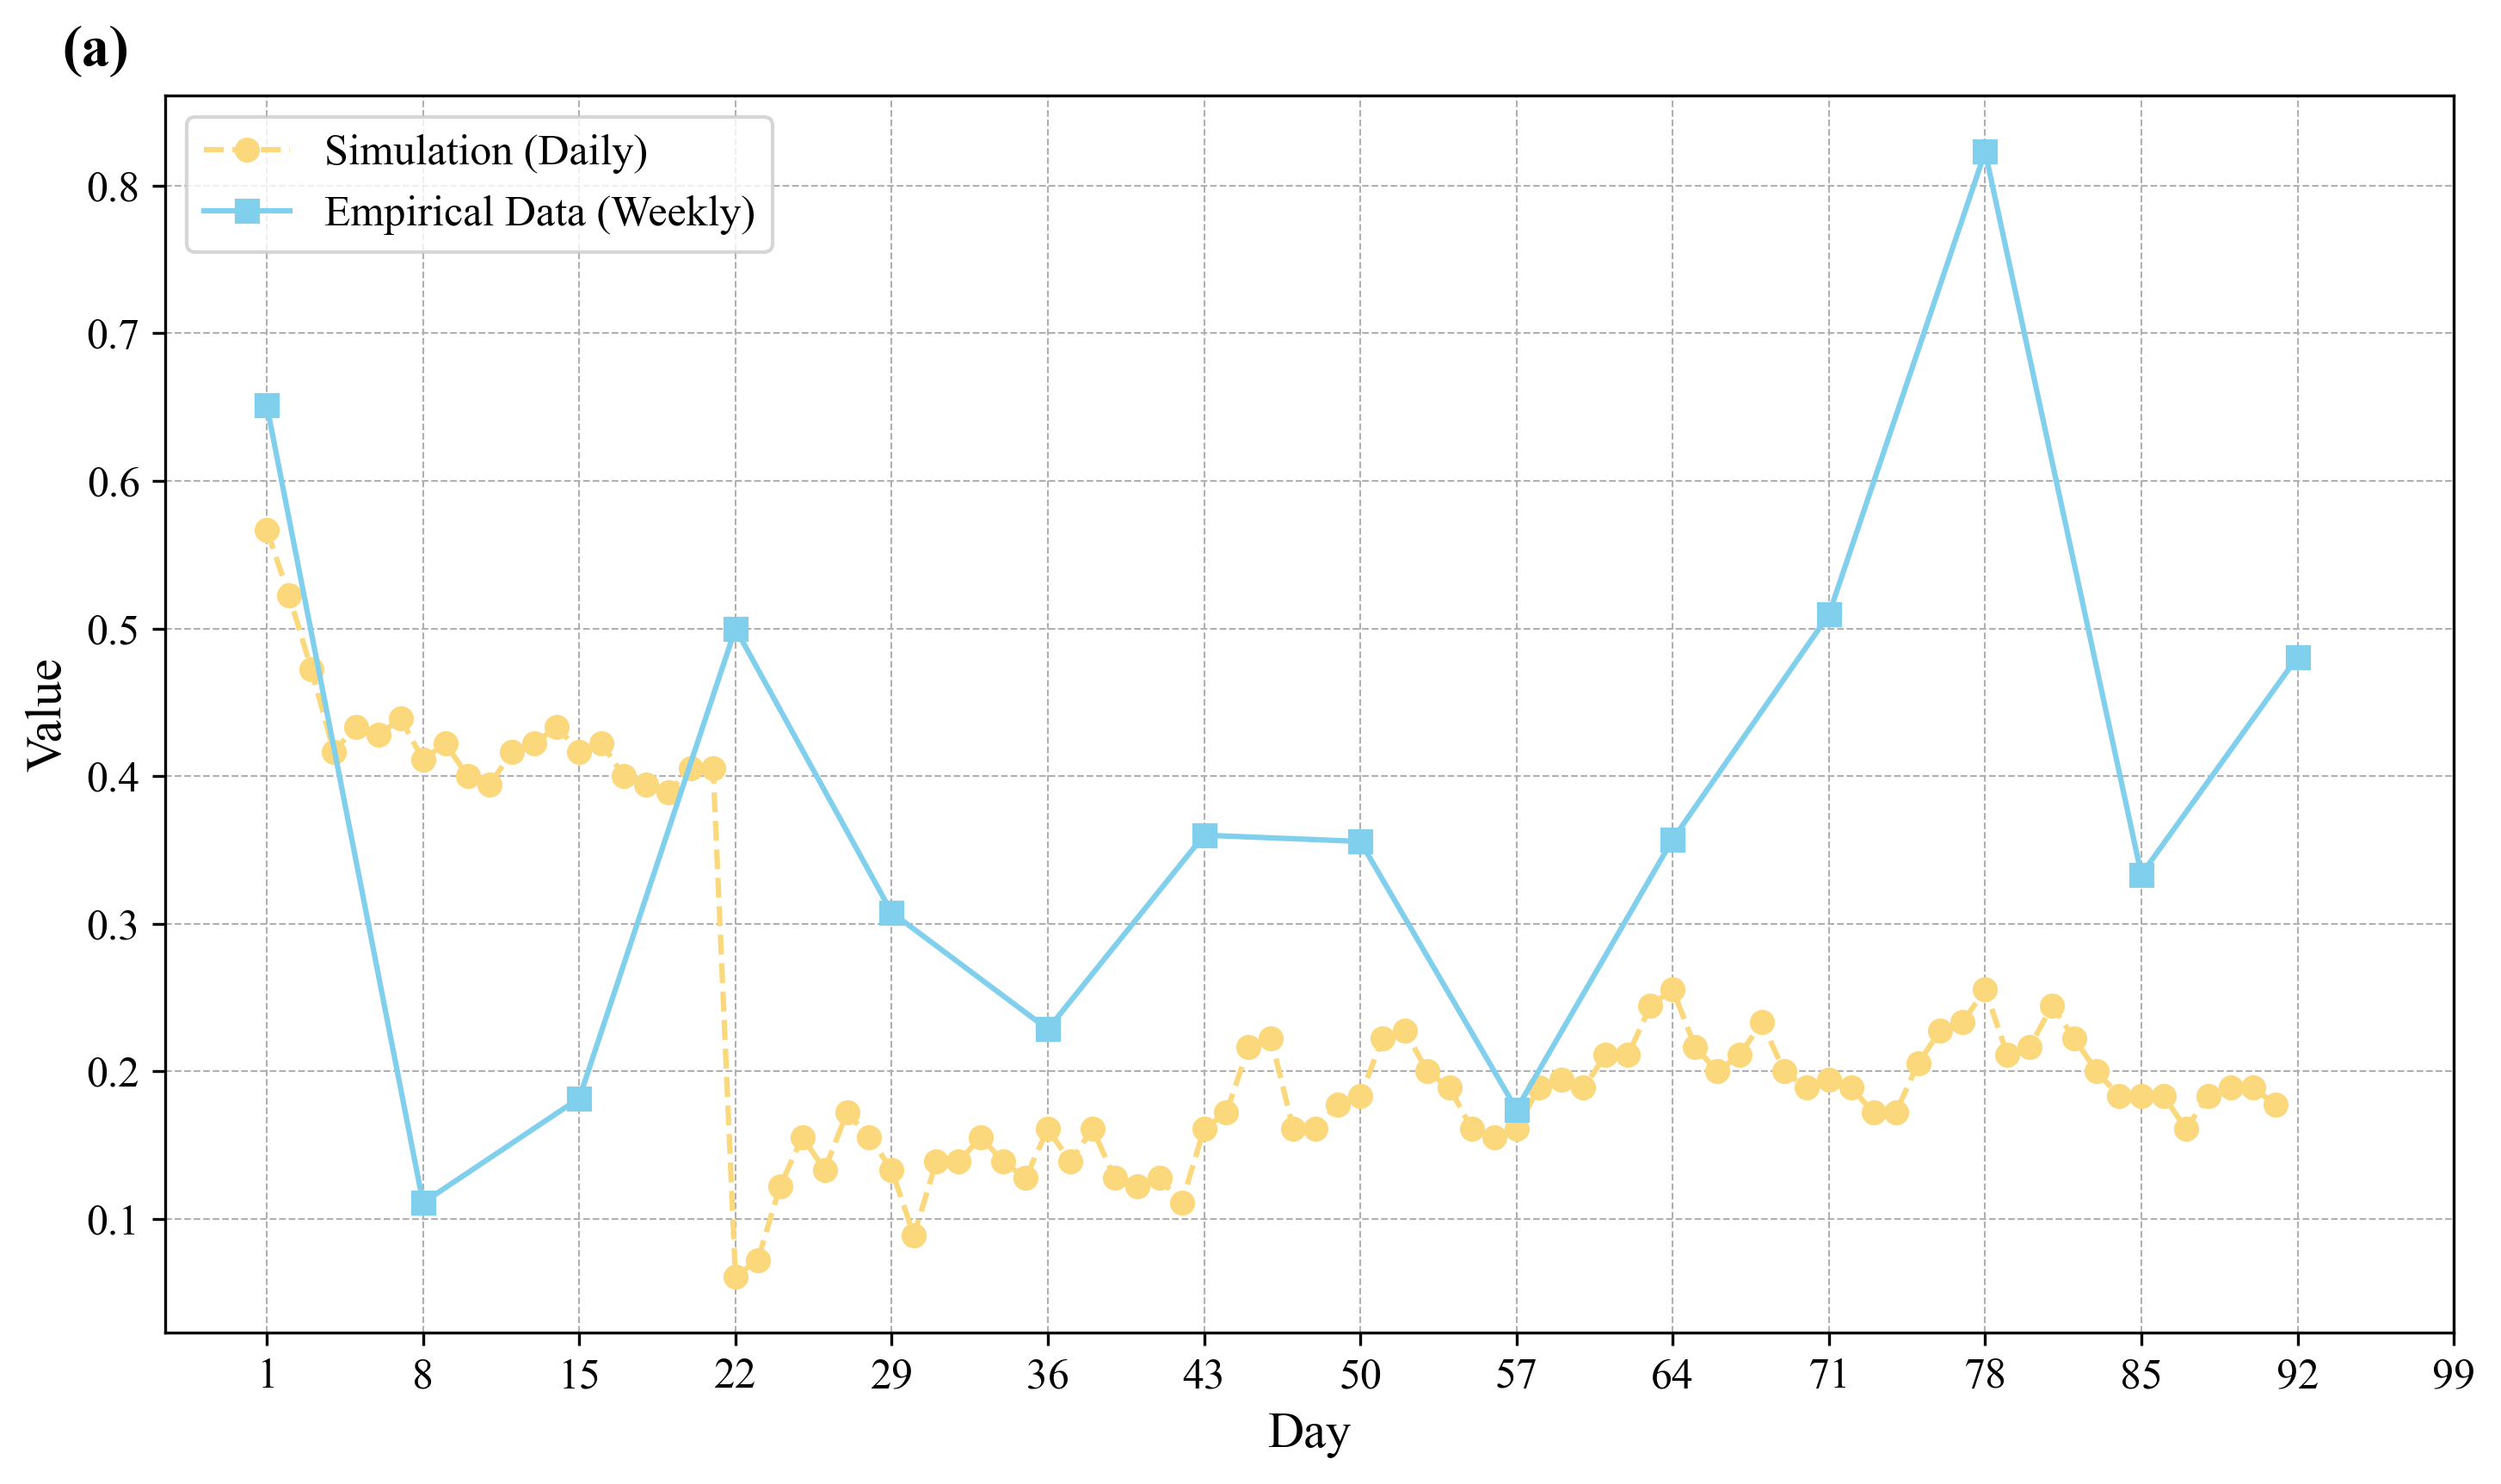

In [27]:
# 确保经验数据的 x 轴和 y 轴长度匹配
simulation_data = graph_data['simulation_data_M_R']
empirical_data = graph_data['empirical_data_M_R']
week_starts = np.arange(1, len(empirical_data) * samples_per_week + 1, samples_per_week)
# 设置字体为 Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

# 创建图形，并设置高分辨率 (dpi=300)
plt.figure(figsize=(10, 6), dpi=300)

# 绘制模拟数据（每日，虚线）
plt.plot(np.arange(1, len(simulation_data[:91]) + 1), simulation_data[:91], linestyle='--', marker='o', color='#FBD87C', label='Simulation (Daily)')

# 绘制经验数据（每周，实线）
plt.plot(week_starts, empirical_data, linestyle='-', marker='s', color='#80CFEC', label='Empirical Data (Weekly)')

# 添加图例、轴标签
plt.legend(fontsize=12)
plt.xlabel('Day', fontsize=14)
plt.ylabel('Value', fontsize=14)

# 添加 (a) 标注在左上角，使用相对图形的坐标放置
plt.text(0.05, 0.95, '(a)', transform=plt.gcf().transFigure, fontsize=16, fontweight='bold', va='top', ha='left')

# 设置学术风格（适合Nature风格）
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(np.arange(1, len(simulation_data) + 1, 7), fontsize=12)  # 每隔一周显示一次x轴标签
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('graph/mainstream_risk.png', dpi=600)

# 显示图形
plt.show()

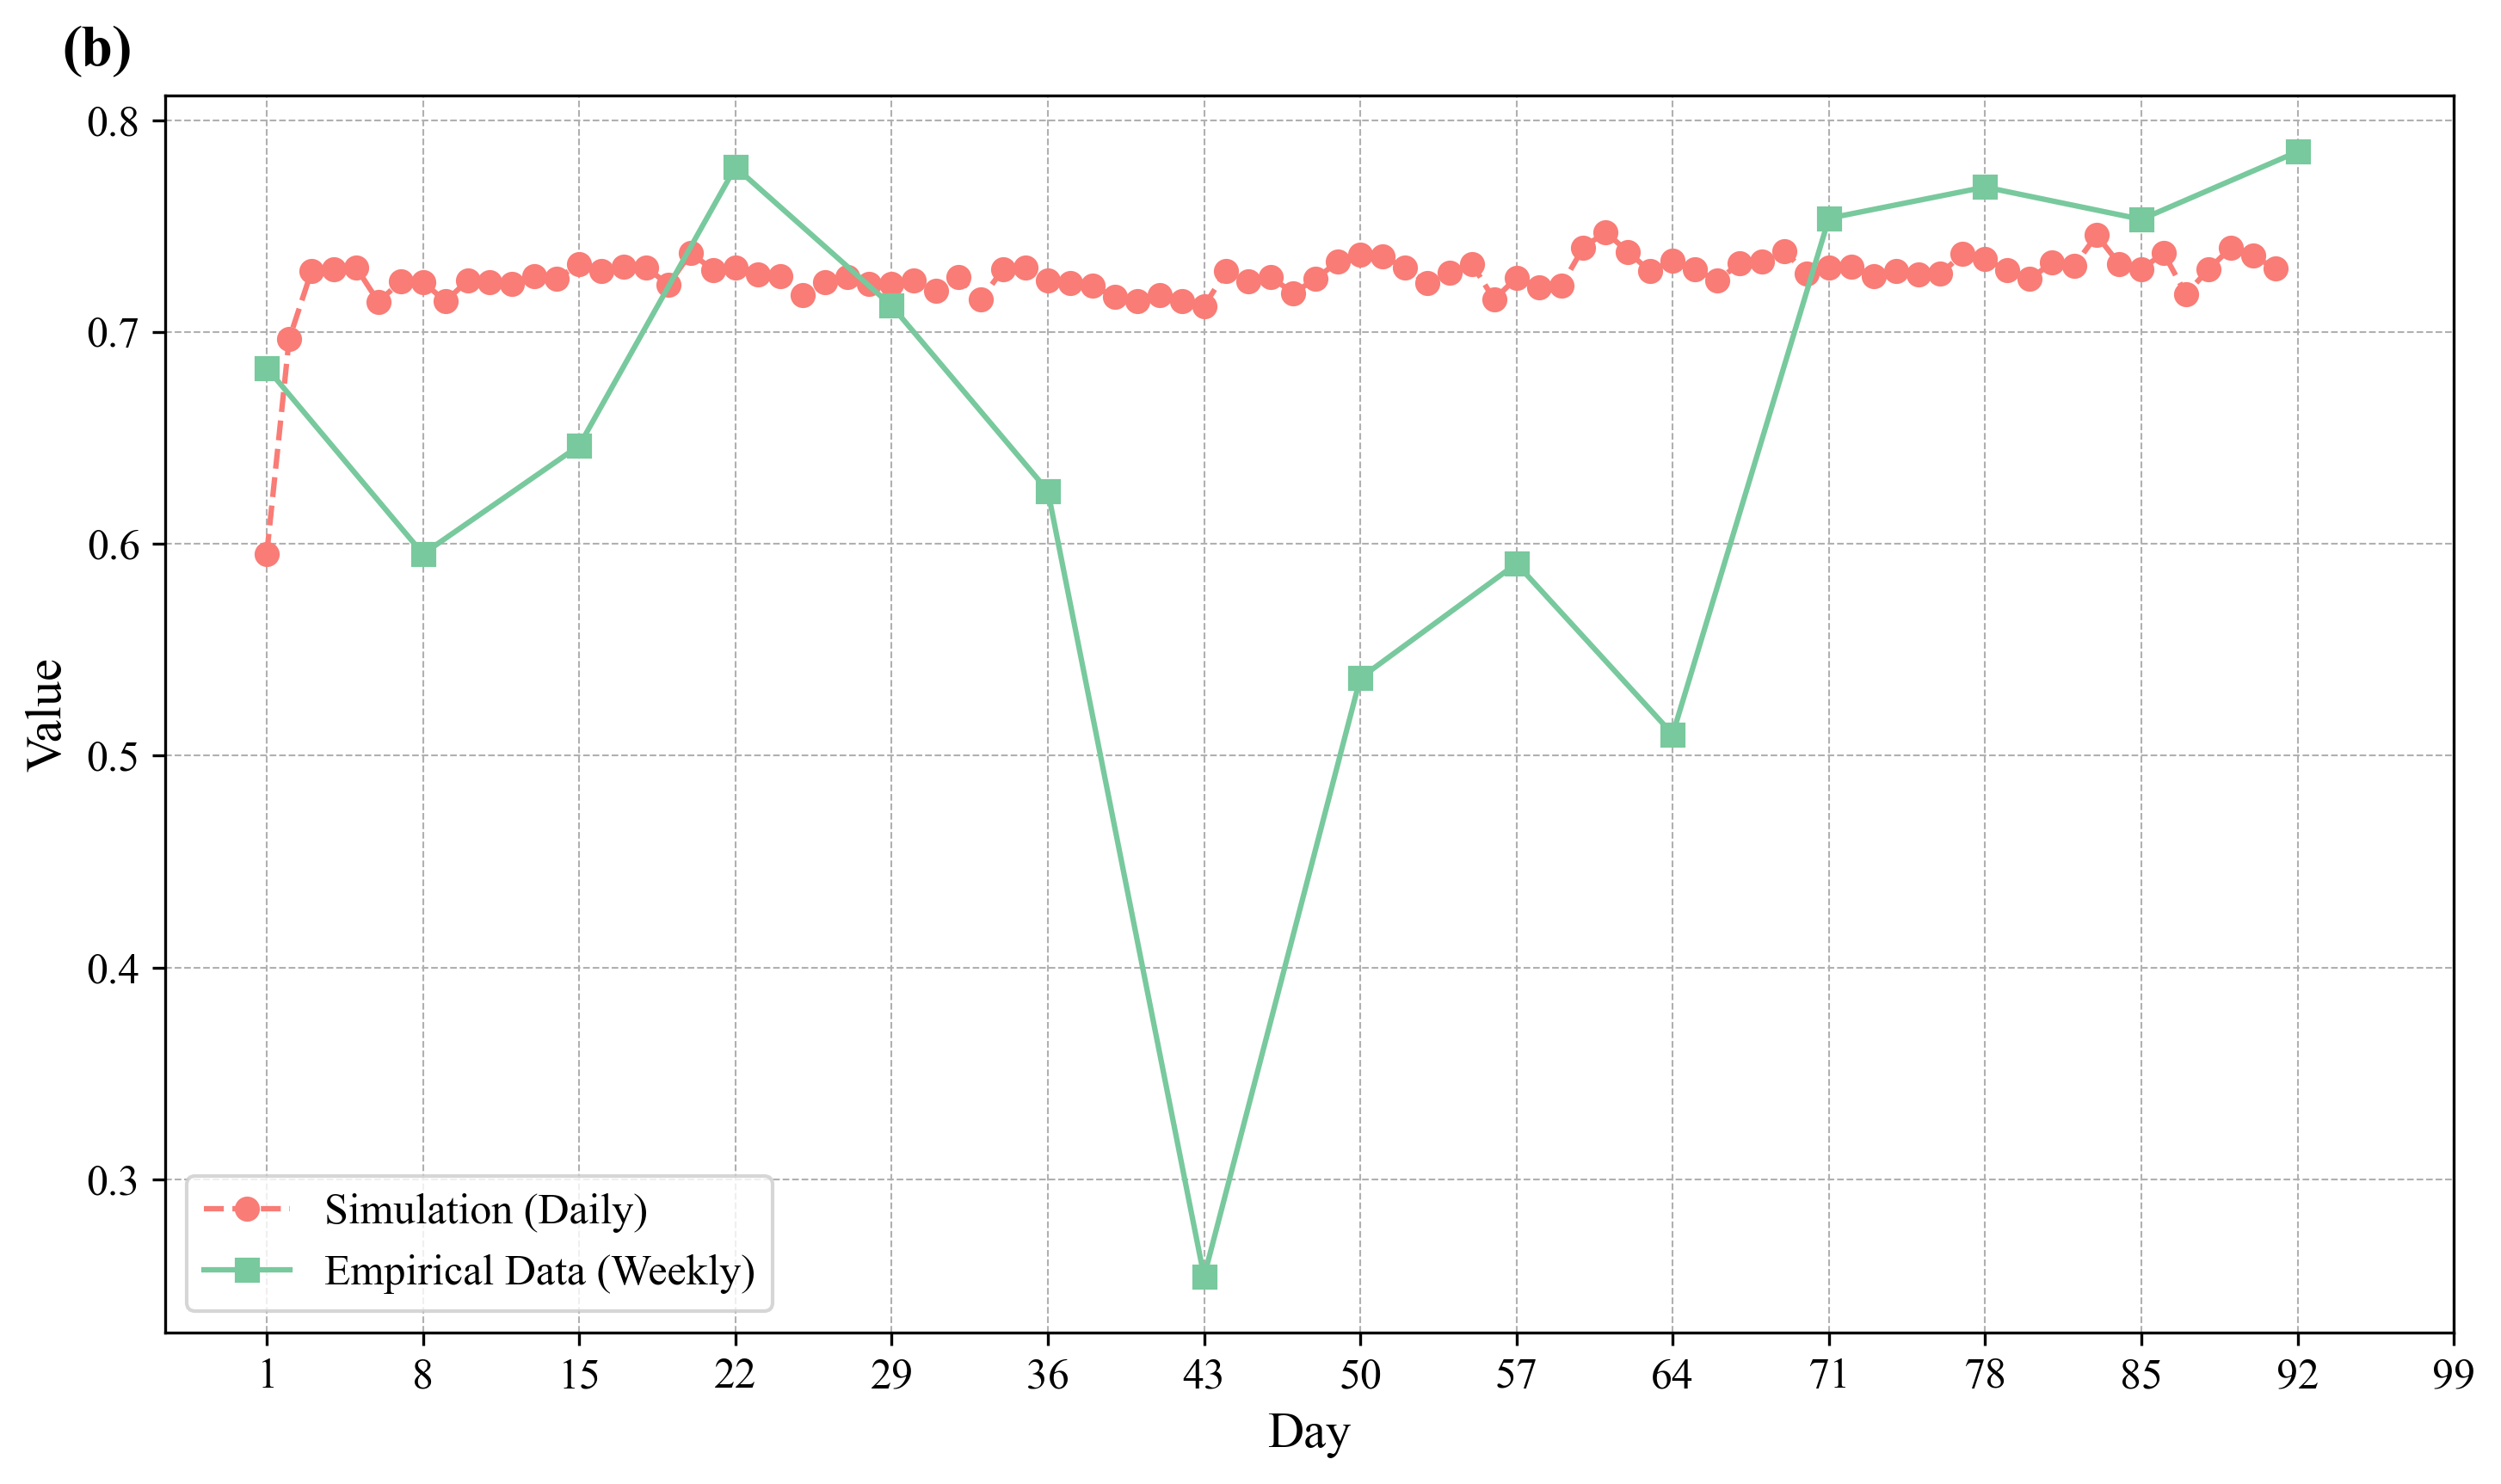

In [26]:
# 确保经验数据的 x 轴和 y 轴长度匹配
simulation_data = graph_data['simulation_data_W_R']
empirical_data = graph_data['empirical_data_W_R']
week_starts = np.arange(1, len(empirical_data) * samples_per_week + 1, samples_per_week)
# 设置字体为 Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

# 创建图形，并设置高分辨率 (dpi=300)
plt.figure(figsize=(10, 6), dpi=300)

# 绘制模拟数据（每日，虚线）
plt.plot(np.arange(1, len(simulation_data[:91]) + 1), simulation_data[:91], linestyle='--', marker='o', color='#F97C76', label='Simulation (Daily)')

# 绘制经验数据（每周，实线）
plt.plot(week_starts, empirical_data, linestyle='-', marker='s', color='#78C99D', label='Empirical Data (Weekly)')

# 添加图例、轴标签
plt.legend(fontsize=12)
plt.xlabel('Day', fontsize=14)
plt.ylabel('Value', fontsize=14)

# 添加 (a) 标注在左上角，使用相对图形的坐标放置
plt.text(0.05, 0.95, '(b)', transform=plt.gcf().transFigure, fontsize=16, fontweight='bold', va='top', ha='left')

# 设置学术风格（适合Nature风格）
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(np.arange(1, len(simulation_data) + 1, 7), fontsize=12)  # 每隔一周显示一次x轴标签
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('graph/wemedia_risk.png', dpi=600)

# 显示图形
plt.show()

In [18]:
graph_data.keys()

dict_keys(['simulation_data_h', 'empirical_data_h', 'simulation_data_m', 'empirical_data_m', 'simulation_data_l', 'empirical_data_l', 'simulation_data_M_R', 'empirical_data_M_R', 'simulation_data_W_R', 'empirical_data_W_R'])

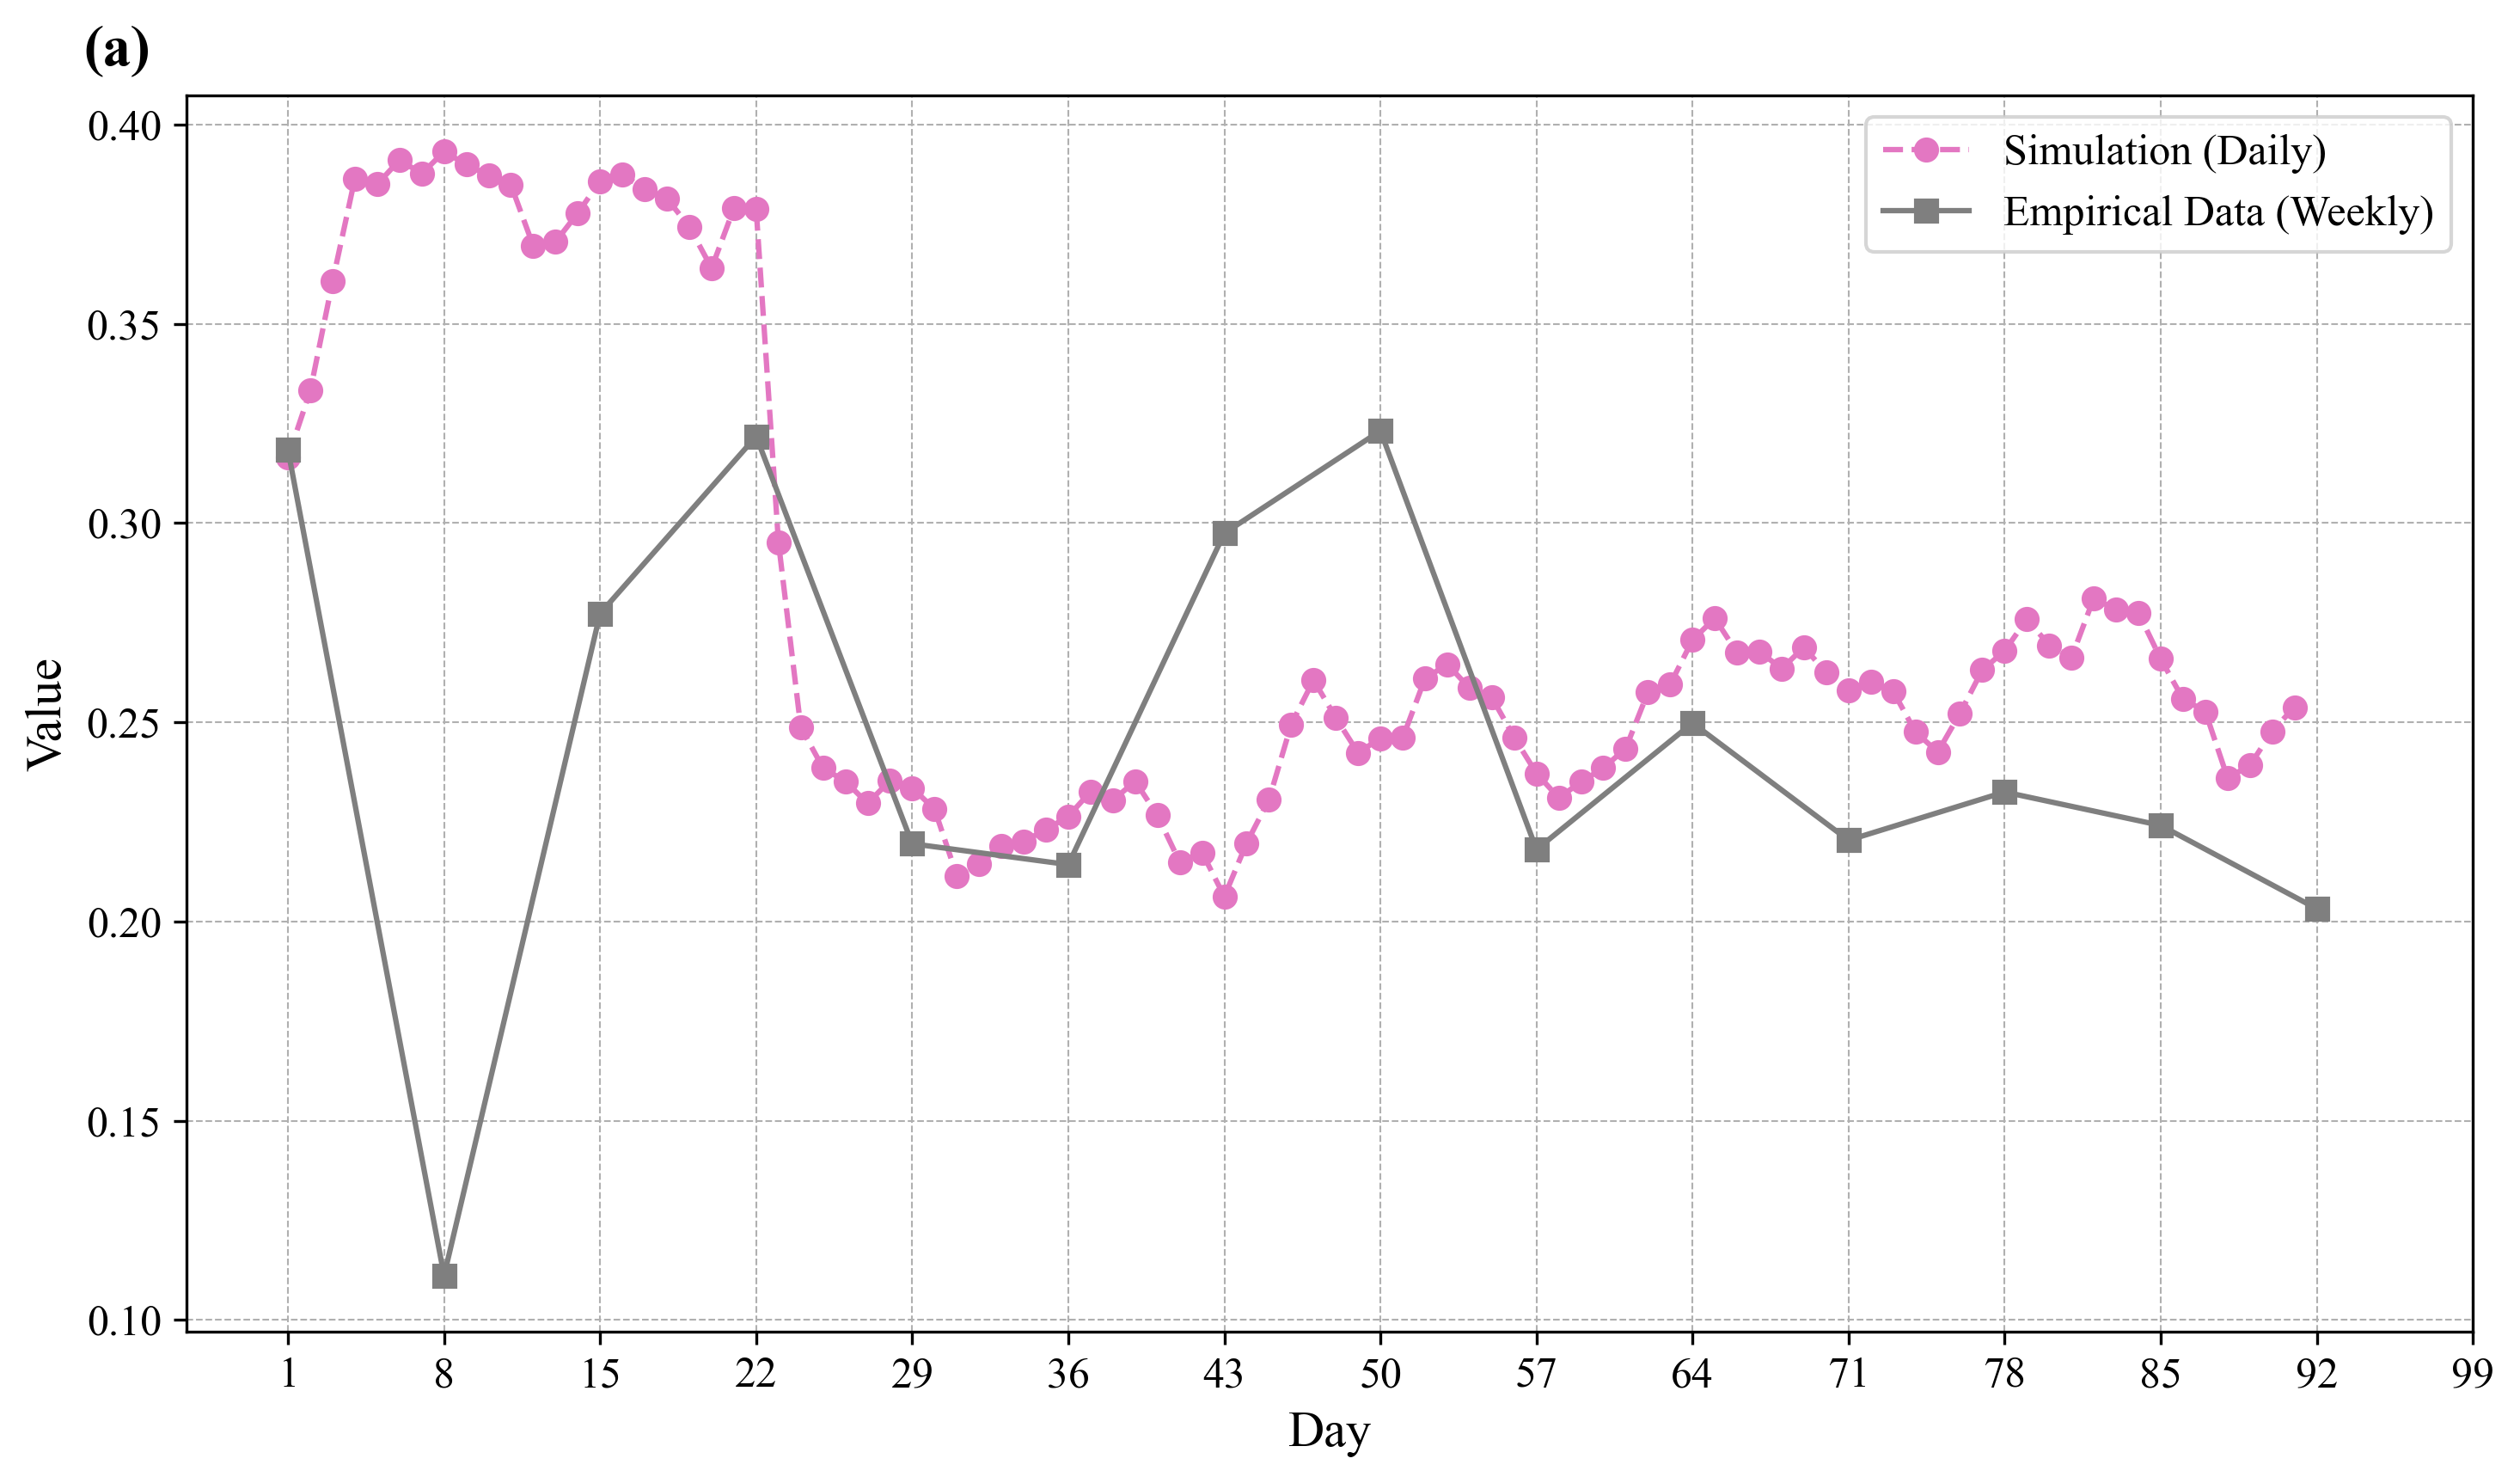

In [28]:
simulation_data = graph_data['simulation_data_h']
empirical_data = graph_data['empirical_data_h']
# 确保经验数据的 x 轴和 y 轴长度匹配
week_starts = np.arange(1, len(empirical_data) * samples_per_week + 1, samples_per_week)
# 设置字体为 Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

# 创建图形，并设置高分辨率 (dpi=300)
plt.figure(figsize=(10, 6), dpi=300)

# 绘制模拟数据（每日，虚线）
plt.plot(np.arange(1, len(simulation_data[:91]) + 1), simulation_data[:91], linestyle='--', marker='o', color='#E377C2', label='Simulation (Daily)')

# 绘制经验数据（每周，实线）
plt.plot(week_starts, empirical_data, linestyle='-', marker='s', color='#7F7F7F', label='Empirical Data (Weekly)')

# 添加图例、轴标签
plt.legend(fontsize=12)
plt.xlabel('Day', fontsize=14)
plt.ylabel('Value', fontsize=14)

# 添加 (a) 标注在左上角，使用相对图形的坐标放置
plt.text(0.05, 0.95, '(a)', transform=plt.gcf().transFigure, fontsize=16, fontweight='bold', va='top', ha='left')

# 设置学术风格（适合Nature风格）
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(np.arange(1, len(simulation_data) + 1, 7), fontsize=12)  # 每隔一周显示一次x轴标签
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('graph/high_arousal.png', dpi=600)
# 显示图形
plt.show()


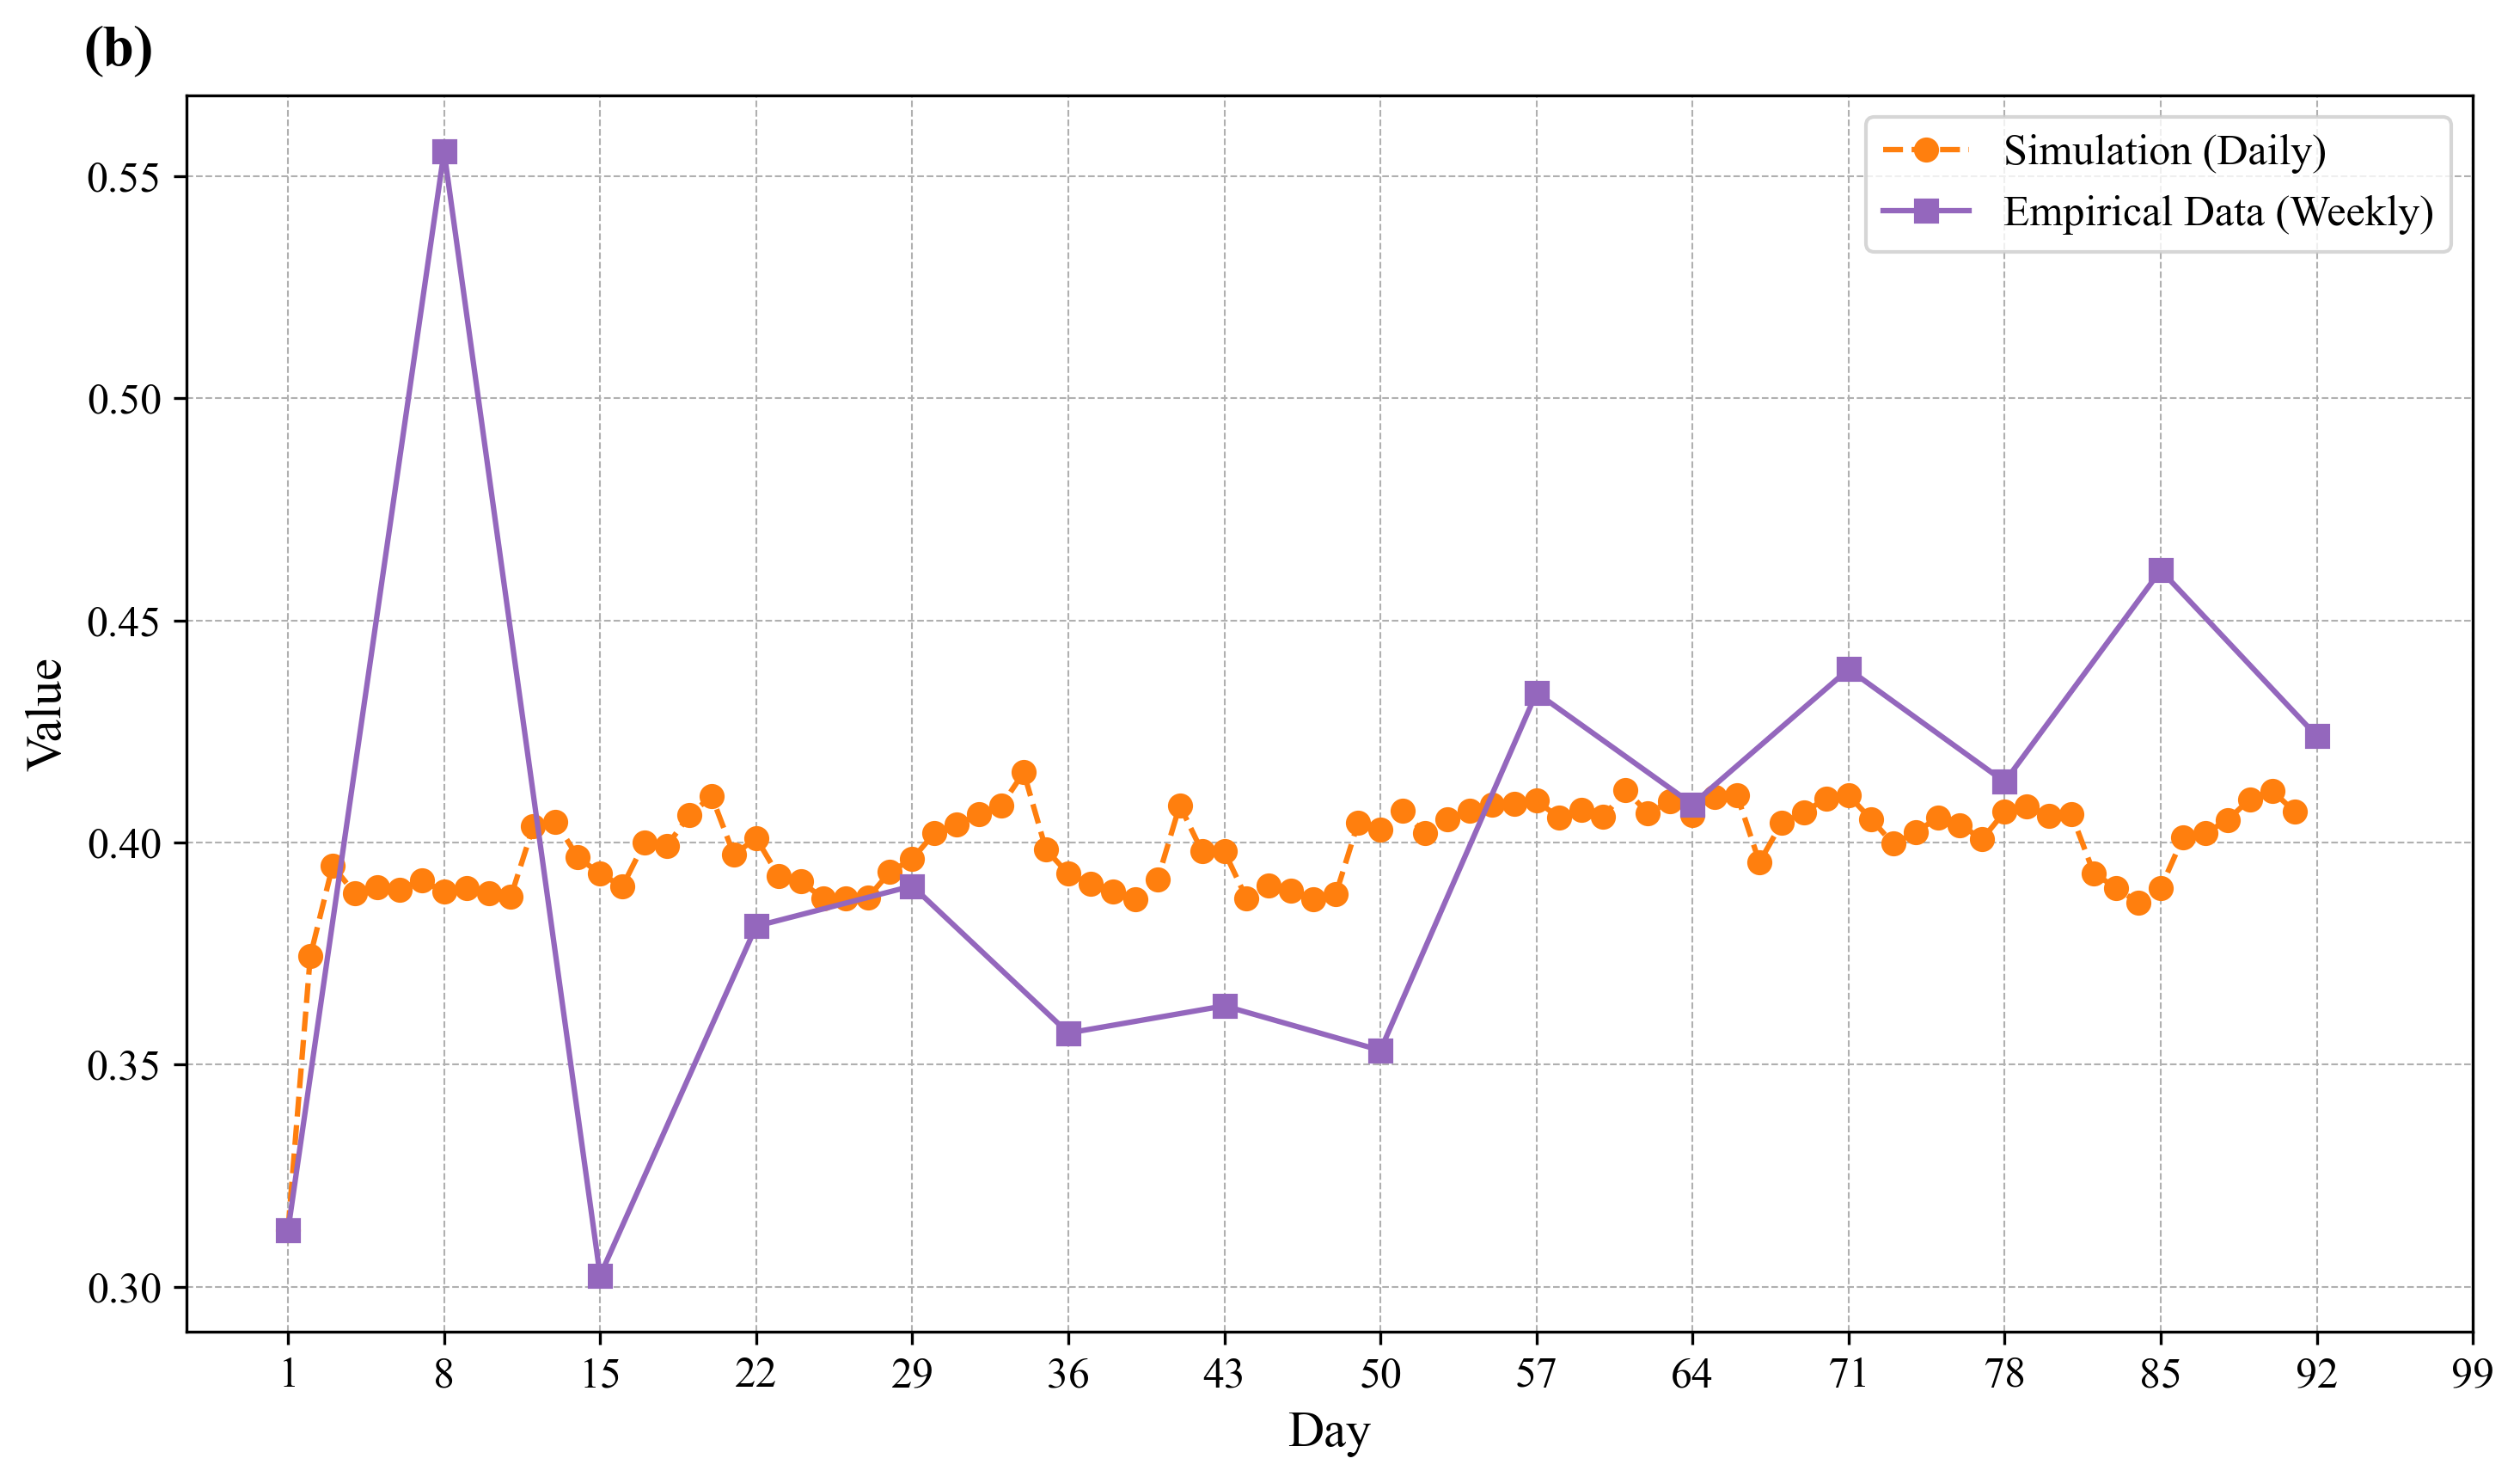

In [22]:
# 确保经验数据的 x 轴和 y 轴长度匹配
simulation_data = graph_data['simulation_data_m']
empirical_data = graph_data['empirical_data_m']
week_starts = np.arange(1, len(empirical_data) * samples_per_week + 1, samples_per_week)
# 设置字体为 Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

# 创建图形，并设置高分辨率 (dpi=300)
plt.figure(figsize=(10, 6), dpi=300)

# 为 c 图选择新的配色方案
simulation_color = '#ff7f0e'  # 橙色
empirical_color = '#9467bd'   # 紫色

# 绘制模拟数据（每日，虚线）
plt.plot(np.arange(1, len(simulation_data[:91]) + 1), simulation_data[:91], linestyle='--', marker='o', color=simulation_color, label='Simulation (Daily)')

# 绘制经验数据（每周，实线）
plt.plot(week_starts, empirical_data, linestyle='-', marker='s', color=empirical_color, label='Empirical Data (Weekly)')

# 添加图例、轴标签
plt.legend(fontsize=12)
plt.xlabel('Day', fontsize=14)
plt.ylabel('Value', fontsize=14)

# 添加 (a) 标注在左上角，使用相对图形的坐标放置
plt.text(0.05, 0.95, '(b)', transform=plt.gcf().transFigure, fontsize=16, fontweight='bold', va='top', ha='left')

# 设置学术风格（适合Nature风格）
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(np.arange(1, len(simulation_data) + 1, 7), fontsize=12)  # 每隔一周显示一次x轴标签
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('graph/middle_arousal.png', dpi=600)

# 显示图形
plt.show()

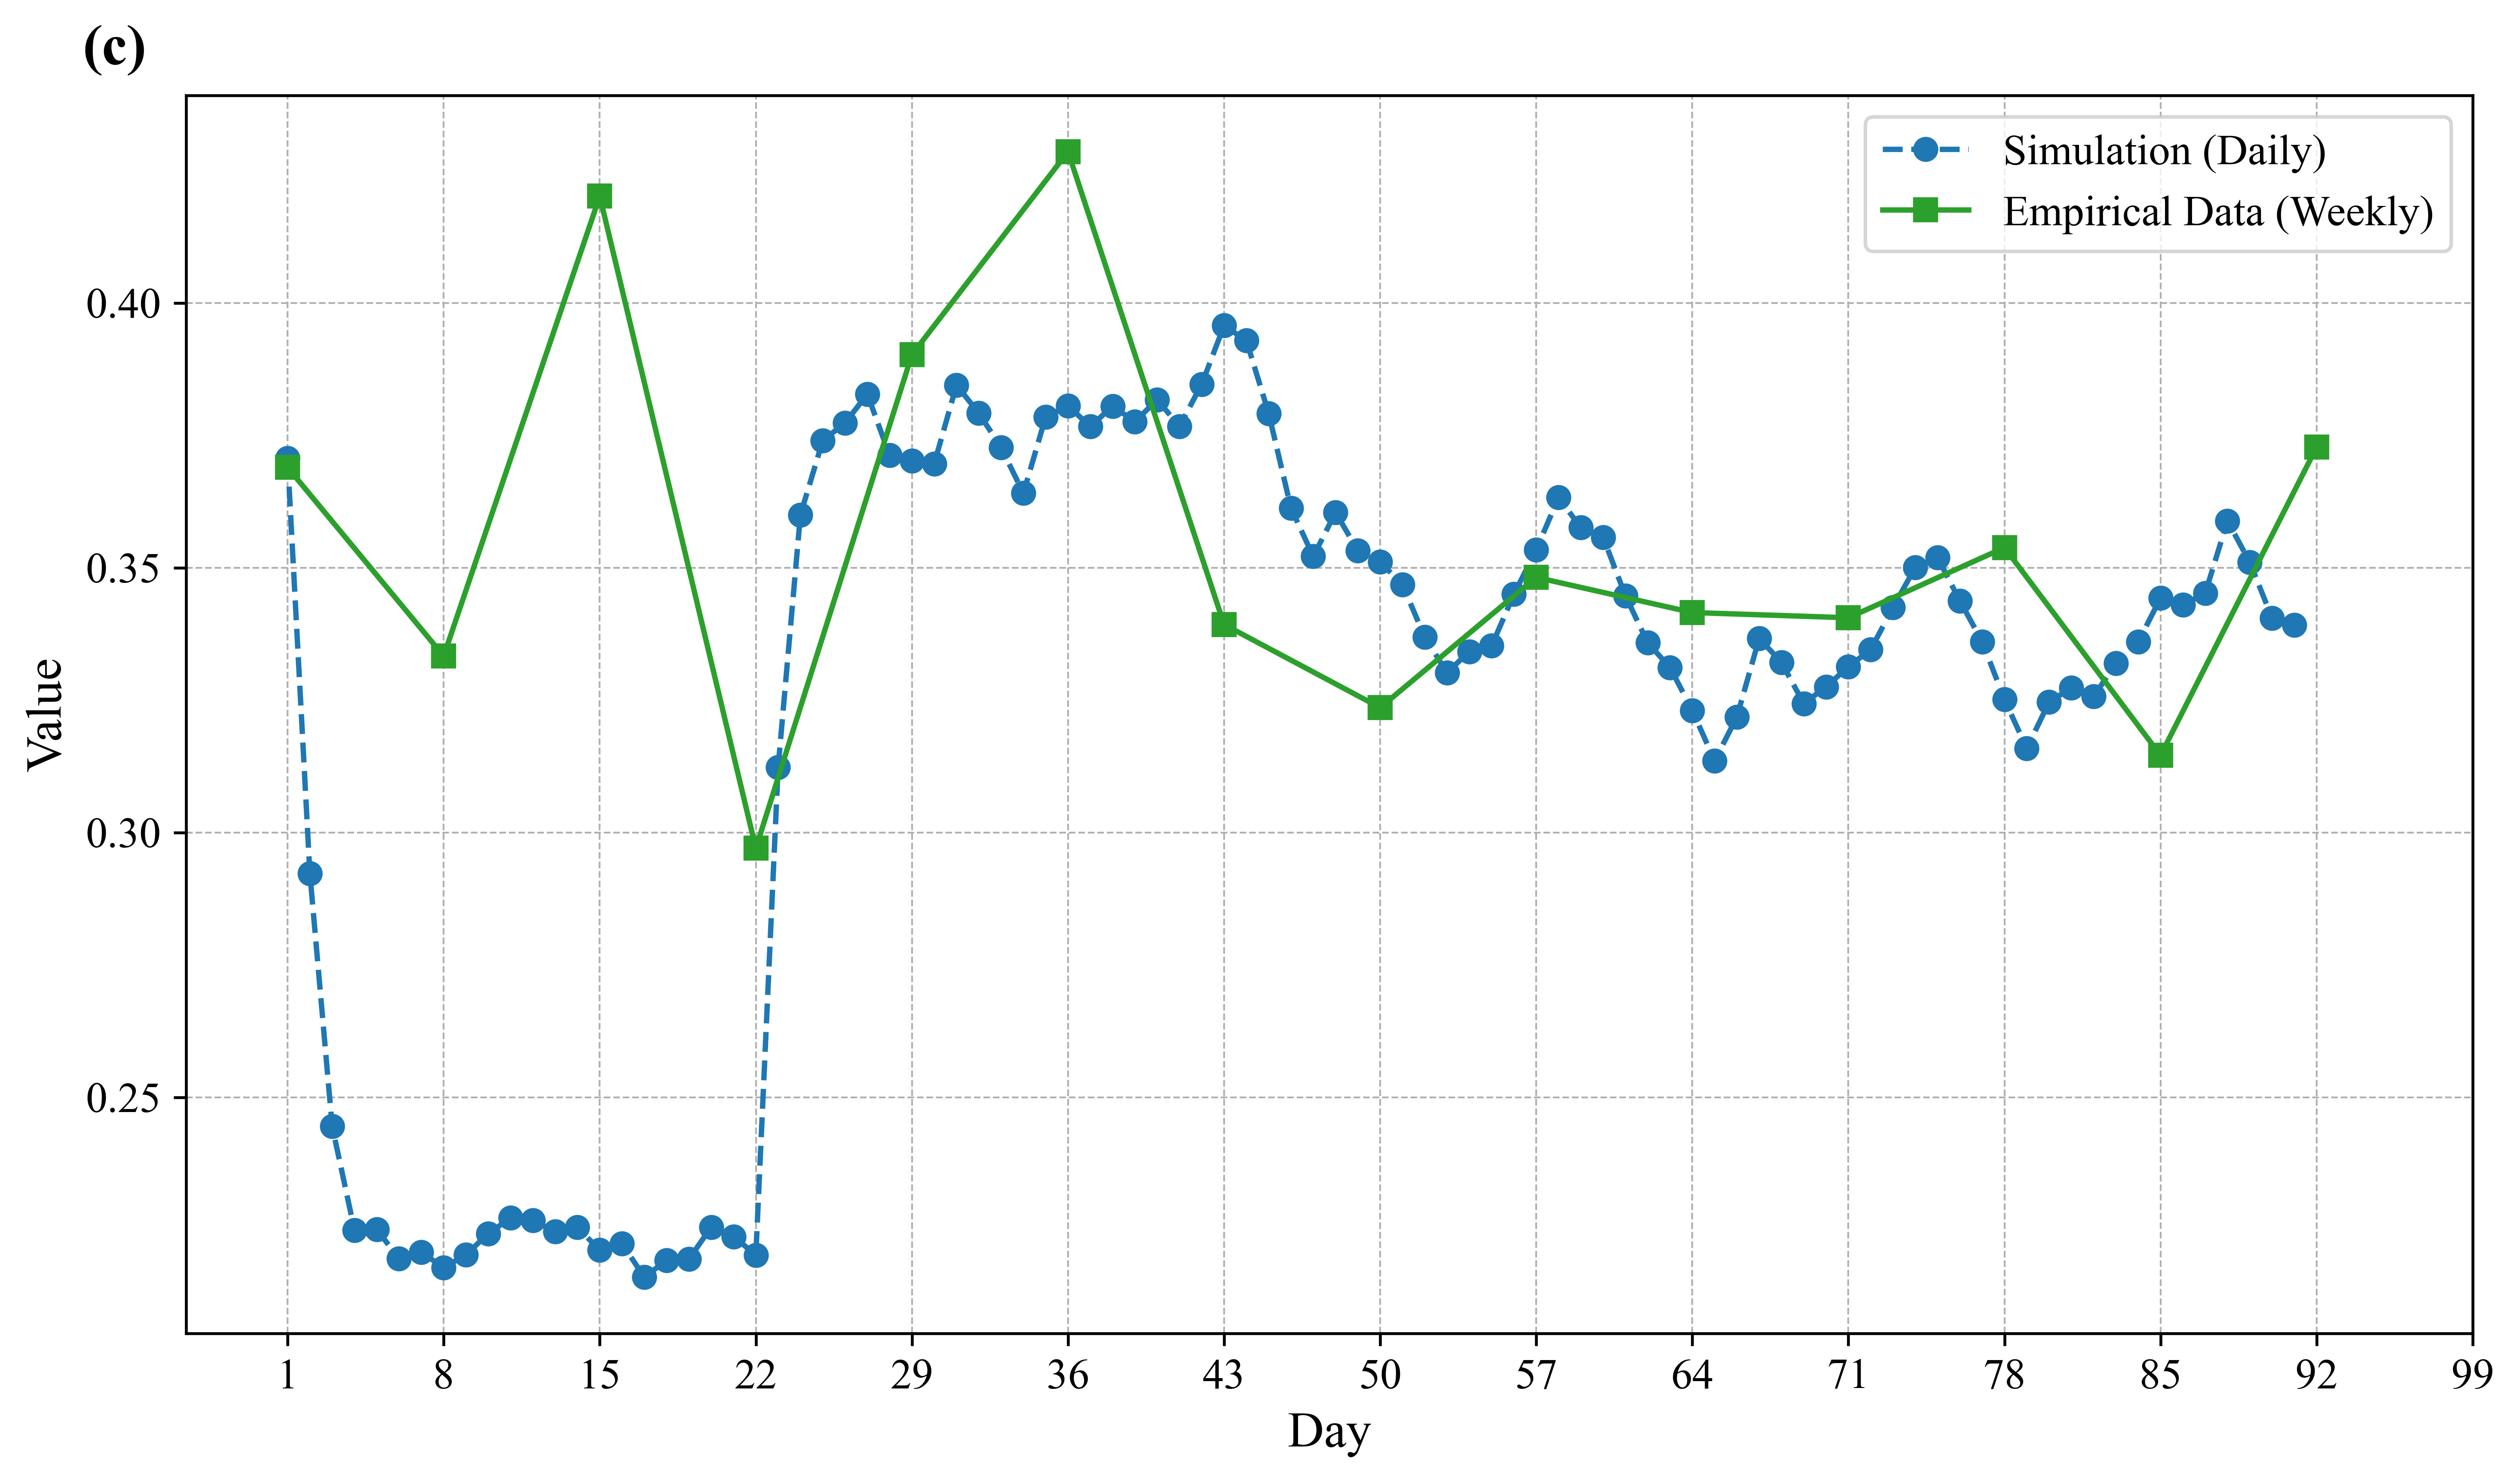

In [23]:
# 确保经验数据的 x 轴和 y 轴长度匹配
simulation_data = graph_data['simulation_data_l']
empirical_data = graph_data['empirical_data_l']
week_starts = np.arange(1, len(empirical_data) * samples_per_week + 1, samples_per_week)

# 设置字体为 Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

# 创建图形，并设置高分辨率 (dpi=300)
plt.figure(figsize=(10, 6), dpi=600)

# 新的配色方案
simulation_color = '#1f77b4'  # 深蓝色
empirical_color = '#2ca02c'   # 绿色

# 绘制模拟数据（每日，虚线），使用新配色
plt.plot(np.arange(1, len(simulation_data[:91]) + 1), simulation_data[:91], linestyle='--', marker='o', color=simulation_color, label='Simulation (Daily)')

# 绘制经验数据（每周，实线），使用新配色
plt.plot(week_starts, empirical_data, linestyle='-', marker='s', color=empirical_color, label='Empirical Data (Weekly)')

# 添加图例、轴标签
plt.legend(fontsize=12)
plt.xlabel('Day', fontsize=14)
plt.ylabel('Value', fontsize=14)

# 添加 (b) 标注在左上角，使用相对图形的坐标放置
plt.text(0.05, 0.95, '(c)', transform=plt.gcf().transFigure, fontsize=16, fontweight='bold', va='top', ha='left')

# 设置学术风格（适合Nature风格）
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(np.arange(1, len(simulation_data) + 1, 7), fontsize=12)  # 每隔一周显示一次x轴标签
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('graph/low_arousal.png', dpi=600)

# 显示图形
plt.show()


## 绘制参数分布图

In [2]:
import pandas as pd
all_results = []
for i  in range(1, 4):
    result_df = pd.read_csv('simulation_results/simulation_results_{}.csv'.format(i))
    all_results.append(result_df)

In [3]:
all_results = pd.concat(all_results)
all_results = all_results.sort_values(by='error')
all_results

result                                              param  \
0     not fitting  (29.67254171778729, 0.6396570415498062, 0.5850...   
0     not fitting  (32.48063650977757, 1.0440896863606717, 0.0155...   
0     not fitting  (16.82578662652784, 1.0482458347721977, 0.4803...   
1     not fitting  (27.658747630788064, 1.6732281401302989, 0.670...   
2     not fitting  (11.153185715854594, 0.4296124373409909, 0.540...   
...           ...                                                ...   
1999  not fitting  (17.326563420516205, 0.022686578302213364, 11....   
9999  not fitting  (29.96777522625877, 0.016444309099209964, 3.05...   
7997  not fitting  (35.52895294711743, 0.06875849995672992, 26.26...   
7998  not fitting  (15.505855922725297, 0.12247632021417948, 26.0...   
7999  not fitting  (47.64929171569763, 0.03506843758883707, 5.078...   

         error      alpha      beta      theta      sigma      zeta       miu  \
0     0.094075  29.672542  0.639657   0.585056  38.574714  0.458808  0.084140   
0     0.094726  32.480637  1.044090   0.015559  22.329786  0.648353  0.135732   
0     0.095515  16.825787  1.048246   0.480396  15.756554  0.612003  0.063317   
1     0.095896  27.658748  1.673228   0.670901  30.487587  0.562115  0.778401   
2     0.099876  11.153186  0.429612   0.540965  33.728813  0.358095  0.970221   
...        ...        ...       ...        ...        ...       ...       ...   
1999  0.283461  17.326563  0.022687  11.865611  29.647050  0.856992  0.686858   
9999  0.285436  29.967775  0.016444   3.057185  22.876591  0.953090  0.204138   
7997  0.285917  35.528953  0.068758  26.267612  30.100947  0.940843  0.472940   
7998  0.286790  15.505856  0.122476  26.055682  25.652822  0.992086  0.059071   
7999  0.289850  47.649292  0.035068   5.078644  17.581188  0.960681  0.582249   

            g_m  ...   delta_3   delta_4   delta_5   delta_6   delta_7  \
0     11.022751  ... -9.251855  2.210788 -3.560652  5.553205 -4.748179   
0     35.671483  ... -8.731251  7.136590 -1.854843  8.208712 -7.202218   
0     19.689076  ... -9.461985  3.942666 -7.528012  6.347039 -7.269965   
1     30.717610  ... -2.246133  6.146608 -7.277607  7.852868 -6.032292   
2     16.573069  ... -0.310500  3.319963 -0.999788  0.948186 -5.688014   
...         ...  ...       ...       ...       ...       ...       ...   
1999  43.692830  ... -3.169884  8.739575 -3.211011  8.958877 -2.795279   
9999  10.145376  ... -8.040972  2.035453 -5.427551  6.033128 -0.371270   
7997  33.710377  ... -5.328513  6.744682 -5.124219  6.224776 -8.058128   
7998   8.873366  ... -9.504825  1.781255 -4.406294  0.257561 -4.245702   
7999  17.116100  ... -4.225487  3.428482 -1.517096  0.769964 -0.630543   

       delta_8   gamma_1   gamma_2   gamma_3   gamma_4  
0     8.479700 -0.361866  0.155488 -0.479549  0.184782  
0     9.967426 -0.192822  0.182069 -0.722742  0.199674  
0     6.634616 -0.755028  0.163434 -0.729456  0.166312  
1     2.847455 -0.730213  0.178507 -0.606804  0.128403  
2     0.122074 -0.108087  0.109391 -0.572686  0.101122  
...        ...       ...       ...       ...       ...  
1999  6.114721 -0.327217  0.189578 -0.286019  0.161108  
9999  1.372811 -0.546874  0.160292 -0.045802  0.113642  
7997  7.861259 -0.516815  0.162210 -0.807562  0.178591  
7998  2.192083 -0.445669  0.102478 -0.429754  0.121843  
7999  4.784088 -0.159352  0.107607 -0.071495  0.147789  

[20000 rows x 22 columns]

In [4]:
# results_df_1 = pd.read_csv('./results_df.csv')
# results_df_2 = pd.read_csv('./results_df_second_part.csv')
# results_df = pd.concat([results_df_1, results_df_2], ignore_index=True)
# 查看误差率小于0.7的样本
results_df_subset = all_results[all_results['error'] < 0.12].drop_duplicates()
results_df_subset = results_df_subset[['alpha', 'beta', 'theta', 'sigma', 'zeta']]
# 计算每个参数的标准化系数（均值为0，方差为1）, 这里不能标准化，因为我的参数是一个分布，而不是求一个标准化系数
# standardized_results = (results_df_subset - results_df_subset.mean()) / results_df_subset.std()

In [28]:
results_df_subset.describe()

alpha        beta       theta       sigma        zeta
count  401.000000  401.000000  401.000000  401.000000  401.000000
mean    24.675109   26.056492    1.558465   25.640388    0.673006
std     14.159728   13.897747    4.047134   14.770693    0.151287
min      0.074797    0.429612    0.015559    0.220434    0.174978
25%     13.064695   14.066579    0.486978   12.473057    0.559644
50%     24.901916   26.649577    0.969454   26.695738    0.674012
75%     36.030896   38.049204    1.559308   38.891254    0.778737
max     49.854070   49.791042   44.607961   49.786127    0.999422

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 设置图表风格为 'seaborn-whitegrid'
plt.style.use('seaborn-whitegrid')

# 设置全局字体为 Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12
plt.rcParams['figure.dpi'] = 600
plt.rcParams['text.usetex'] = False

# 创建一个 1x5 的图表布局
fig, axes = plt.subplots(1, 5, figsize=(24, 12))

# 参数列和标题
params = ['alpha', 'beta', 'theta', 'sigma', 'zeta']
titles = [r'$\alpha$ (Social Stability)', r'$\beta$ (Popularity)', r'$\theta$ (Fear Appeal)', r'$\sigma$ (Homophily)', r'$\zeta$ (Selection)']
colors = ["skyblue", "olive", "gold", "#78B49E", "#D78056"]  # 每个子图的颜色

# 依次绘制参数的分布并添加均值和 ±3标准误差线
for i, param in enumerate(params):
    # 获取当前参数的数据
    param_data = results_df_subset[param]
    mean = param_data.mean()
    std_error = param_data.std() / np.sqrt(len(param_data))  # 标准误差 = 标准差 / 样本数的平方根
    
    # 绘制分布图
    # 绘制分布图并设置灰色虚线的 KDE 曲线
    sns.histplot(param_data, kde=True, stat="density", color=colors[i], ax=axes[i], 
                 line_kws={'color': 'gray', 'linestyle': '--'})  # 设置灰色虚线的KDE
    axes[i].set_title(titles[i])

    # 获取 y 轴范围，以控制误差线的高度
    y_min, y_max = axes[i].get_ylim()

    # 在顶部绘制均值点
    axes[i].plot(mean, y_max * 0.98, 'o', color=colors[i], label='Mean', markersize=4)  # 红色圆形实心点，放置在顶部

    # 绘制误差线（±3 标准误差）
    axes[i].hlines(y=y_max * 0.98, xmin=mean - 3 * std_error, xmax=mean + 3 * std_error, colors='#939598', linestyles='-', label=r'$\pm3$ Std Error', linewidth=2)

    # 添加竖杠到误差区间两端
    cap_height = y_max * 0.01  # 设置竖杠的高度
    axes[i].vlines(x=mean - 3 * std_error, ymin=y_max * 0.98 - cap_height / 2, ymax=y_max * 0.98 + cap_height / 2, colors='#939598', linewidth=2)
    axes[i].vlines(x=mean + 3 * std_error, ymin=y_max * 0.98 - cap_height / 2, ymax=y_max * 0.98 + cap_height / 2, colors='#939598', linewidth=2)

    # 只在第一个子图显示图例
    if i == 0:
        axes[i].legend()

# 移除x轴标签
for ax in axes:
    ax.set_xlabel('')

# 调整布局和标题等细节
plt.tight_layout()
# plt.savefig('graph/parameter_distribution_with_mean_and_3se_bars.png', dpi=600)

# 显示图表
plt.show()


C:\Users\wujlin\AppData\Local\Temp\ipykernel_24732\4228680749.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 设置图表风格为 'seaborn-whitegrid'
plt.style.use('seaborn-whitegrid')

# 设置全局字体为 Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
# 设置title的字体大小
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['figure.dpi'] = 600
plt.rcParams['text.usetex'] = False

# 创建一个 1x5 的图表布局
fig, axes = plt.subplots(1, 5, figsize=(24, 12))

# 参数列和标题
params = ['alpha', 'beta', 'theta', 'sigma', 'zeta']
titles = [r'$\alpha$ (Social Stability)', r'$\beta$ (Popularity)', r'$\theta$ (Fear Appeal)', r'$\sigma$ (Homophily)', r'$\zeta$ (Selection)']
colors = ["skyblue", "olive", "gold", "#78B49E", "#D78056"]  # 每个子图的颜色

# 依次绘制参数的分布并添加均值和 ±3标准误差线
for i, param in enumerate(params):
    # 获取当前参数的数据
    param_data = results_df_subset[param]
    mean = param_data.mean()
    std_error = param_data.std() / np.sqrt(len(param_data))  # 标准误差 = 标准差 / 样本数的平方根
    
    # 首先绘制直方图，不绘制 KDE
    sns.histplot(param_data, stat="density", color=colors[i], ax=axes[i])

    # 然后单独绘制灰色虚线的KDE曲线
    sns.kdeplot(param_data, color='gray', linestyle='--', ax=axes[i])

    axes[i].set_title(titles[i])

    # 获取 y 轴范围，以控制误差线的高度
    y_min, y_max = axes[i].get_ylim()

    # 在顶部绘制均值点
    axes[i].plot(mean, y_max * 0.98, 'o', color=colors[i], label='Mean', markersize=4)  # 使用各自的颜色绘制均值点

    # 绘制误差线（±3 标准误差）
    axes[i].hlines(y=y_max * 0.98, xmin=mean - 3 * std_error, xmax=mean + 3 * std_error, colors='#939598', linestyles='-', label=r'$\pm3$ Std Error', linewidth=2)

    # 添加竖杠到误差区间两端
    cap_height = y_max * 0.01  # 设置竖杠的高度
    axes[i].vlines(x=mean - 3 * std_error, ymin=y_max * 0.98 - cap_height / 2, ymax=y_max * 0.98 + cap_height / 2, colors='#939598', linewidth=2)
    axes[i].vlines(x=mean + 3 * std_error, ymin=y_max * 0.98 - cap_height / 2, ymax=y_max * 0.98 + cap_height / 2, colors='#939598', linewidth=2)

    # 只在第3个子图显示图例
    if i == 2:
        axes[i].legend()

# 移除x轴标签
for ax in axes:
    ax.set_xlabel('')

# 移除第二个以后的y轴标签
for ax in axes[1:]:
    ax.set_ylabel('')

# 调整布局和标题等细节
plt.tight_layout()
plt.savefig('graph/parameter_distribution_with_mean_and_3se_bars.png', dpi=600)

# 显示图表
plt.show()


C:\Users\wujlin\AppData\Local\Temp\ipykernel_24732\3009829553.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


## 绘制主题帖子分布

In [1]:
import pandas as pd
import numpy as np
import os

In [4]:
# 选择data文件夹，开头为#的文件名
data_folder = './data'
file_list = os.listdir(data_folder)
file_list = [file for file in file_list if file[0] == '#']
file_list

['#专家称目前无证据表明新冠有后遗症#.csv',
 '#中国团队新冠后遗症研究#.csv',
 '#新冠后遗症#.csv',
 '#新冠后遗症可持续数周数月甚至更长时间#.csv',
 '#新冠后遗症纪录片#.csv',
 '#新冠后遗症覆盖范围广#.csv',
 '#新冠病毒最可怕的后遗症#.csv',
 '#新冠肺炎治愈后是否有后遗症#.csv',
 '#新冠肺炎治愈后还会不会有后遗症#.csv',
 '#白宫承认拜登出现新冠后遗症#.csv',
 '#钟南山说无症状感染者基本无新冠后遗症#.csv',
 '#难忍新冠后遗症美国一ceo自杀#.csv']

In [5]:
# 计算每个文件下面的数据样本量
for file in file_list:
    data = pd.read_csv(f'{data_folder}/{file}')
    print(f'{file}: {len(data)}')

#专家称目前无证据表明新冠有后遗症#.csv: 2278
#中国团队新冠后遗症研究#.csv: 297
#新冠后遗症#.csv: 7484
#新冠后遗症可持续数周数月甚至更长时间#.csv: 966
#新冠后遗症纪录片#.csv: 386
#新冠后遗症覆盖范围广#.csv: 129
#新冠病毒最可怕的后遗症#.csv: 804
#新冠肺炎治愈后是否有后遗症#.csv: 988
#新冠肺炎治愈后还会不会有后遗症#.csv: 124
#白宫承认拜登出现新冠后遗症#.csv: 28
#钟南山说无症状感染者基本无新冠后遗症#.csv: 289
#难忍新冠后遗症美国一ceo自杀#.csv: 149
